In [94]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bankruptcy-detection/__results__.html
/kaggle/input/bankruptcy-detection/__notebook_source__.ipynb
/kaggle/input/bankruptcy-detection/__resultx__.html
/kaggle/input/bankruptcy-detection/__notebook__.ipynb
/kaggle/input/bankruptcy-detection/__output__.json
/kaggle/input/bankruptcy-detection/custom.css
/kaggle/input/bankruptcy-detection/__results___files/__results___47_0.png
/kaggle/input/bankruptcy-detection/__results___files/__results___20_0.png
/kaggle/input/bankruptcy-detection/__results___files/__results___61_0.png
/kaggle/input/bankruptcy-detection/__results___files/__results___19_0.png
/kaggle/input/bankruptcy-detection/__results___files/__results___22_0.png
/kaggle/input/bankruptcy-detection/__results___files/__results___35_0.png
/kaggle/input/bankruptcy-detection/__results___files/__results___27_0.png
/kaggle/input/bankruptcy-detection/__results___files/__results___58_0.png
/kaggle/input/bankruptcy-detection/__results___files/__results___51_0.png
/kaggle/input/bank

# **1. 데이터 불러오기

In [95]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold,cross_val_score,StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import KFold,cross_val_score,StratifiedKFold,GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier

from warnings import simplefilter
simplefilter("ignore")

In [96]:
# 데이터 불러오기
pd.set_option('display.max_columns', None)

data = pd.read_csv('/kaggle/input/bankruptcy-data/data.csv')

data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256970e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820930e-04,1.165010e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897850e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.0068

5 rows * 96 columns

데이터 중에서 null value나 겹치는 데이터 있는지 확인하기

In [97]:
data.columns[data.isnull().any()]

Index([], dtype='object')

In [98]:
data.duplicated().sum()

0

이로써 데이터에 null value, duplicated 데이터 없는거 확인함

data quality check

In [99]:
# Dimension
print("\nData dimension :")
print("Number of Records : ",data.shape[0],"\nNumber of Features : ",data.shape[1])

# Datatype of columns
print("\nDatatype of Features :")
print(data.dtypes.value_counts())


Data dimension :
Number of Records :  6819 
Number of Features :  96

Datatype of Features :
float64    93
int64       3
Name: count, dtype: int64


# **2. EDA하기 **

**2.1 내 데이터가 balanced 인지 imbalanced인지 확인하기**

In [100]:
val = data['Bankrupt?'].value_counts().reset_index(name='count')

val

,Bankrupt?,count
0,0,6599
1,1,220


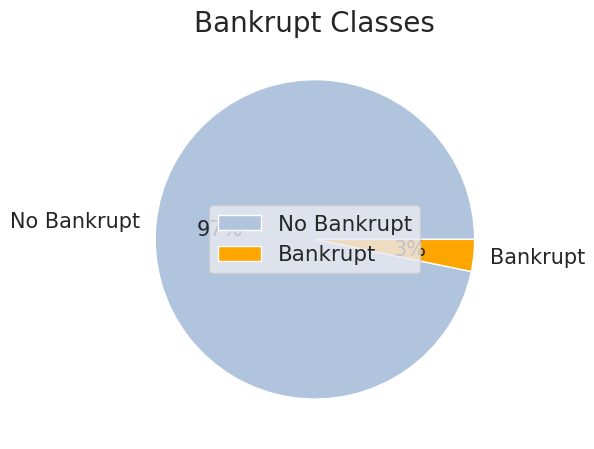

In [101]:
def label_function(val):
    return f'{val:.0f}%'

labels = ['No Bankrupt','Bankrupt']

val.plot(x='Bankrupt?',y='count',kind='pie',autopct=label_function,
                textprops={'fontsize':15},labels=labels,colors=['lightsteelblue','orange'])

plt.ylabel('')
plt.title('Bankrupt Classes',fontsize=20)

plt.tight_layout()

위 그래프에서 볼 수 있다 싶이, No Bankrupt로 매우 치우쳐져 있음을 알 수 있었음. data resampling이 필수임을 깨달음.

**2-2. 내 데이터의 outliers 확인하기**

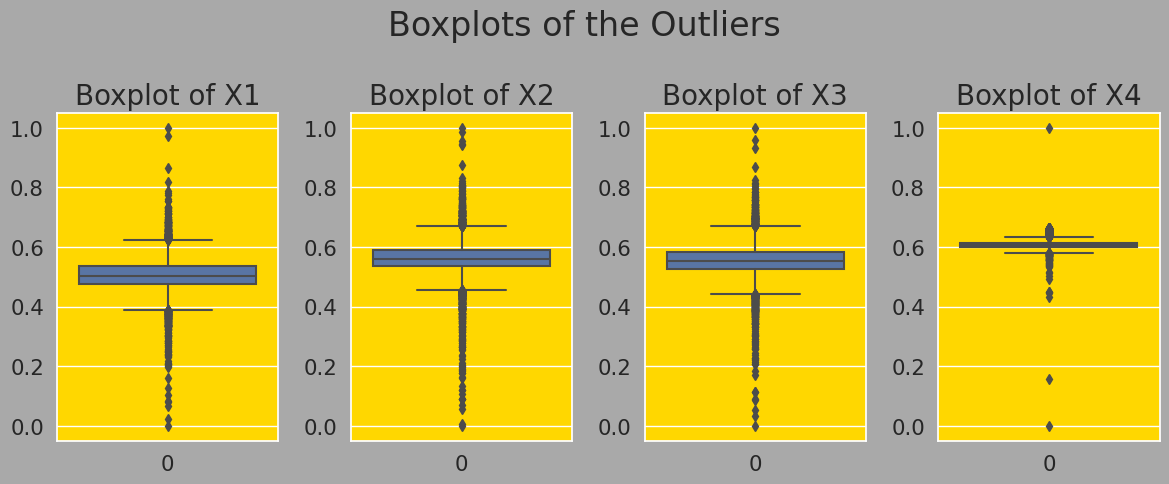

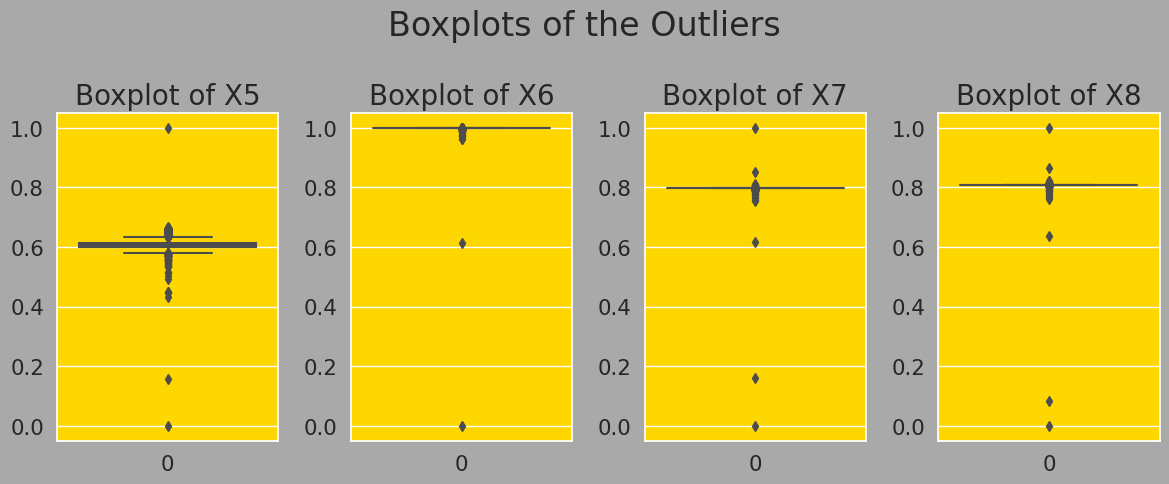

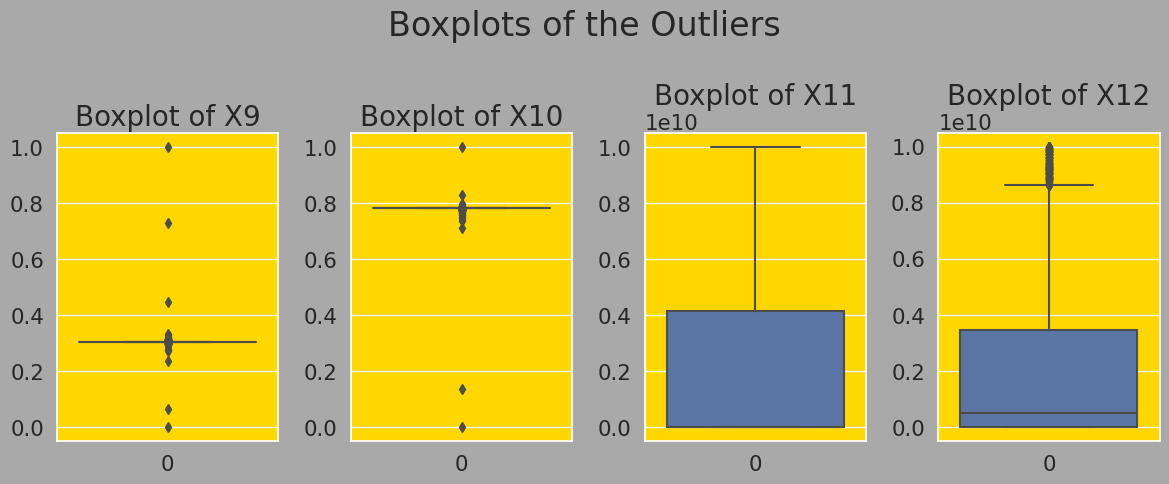

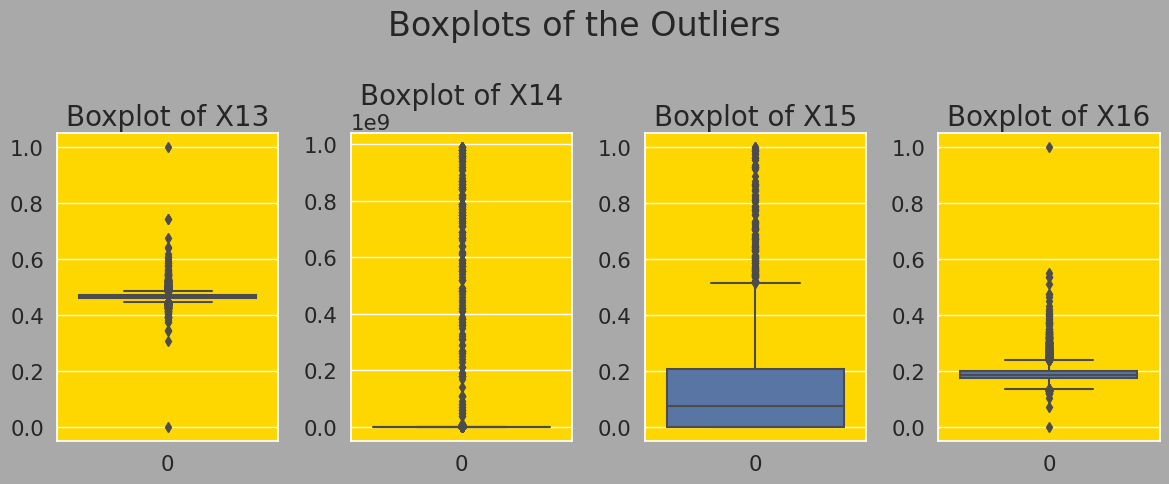

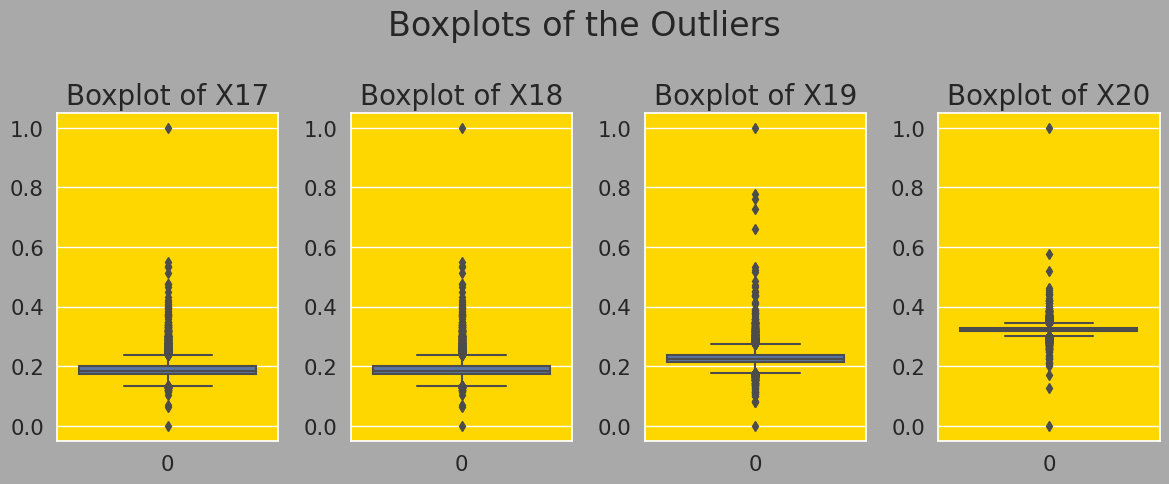

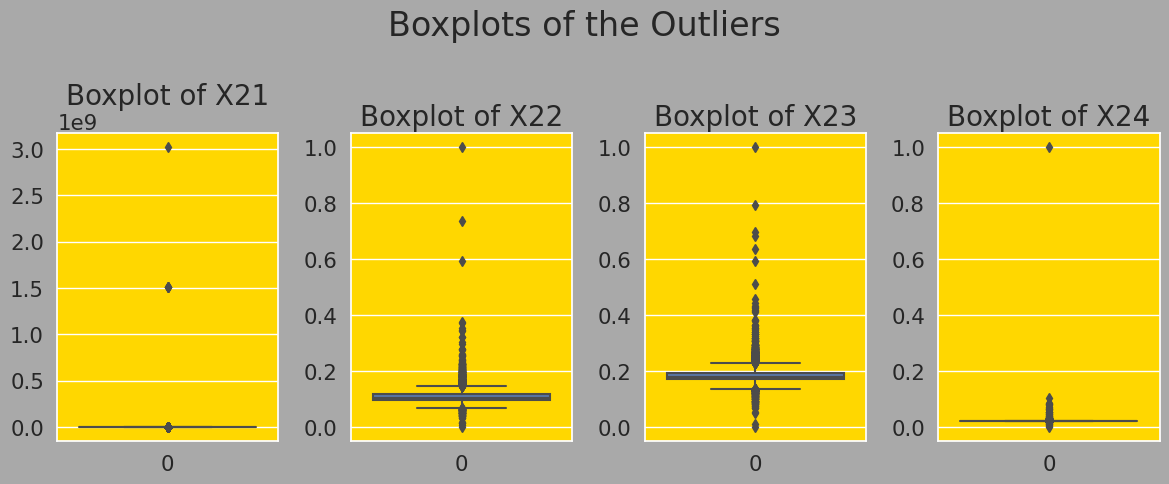

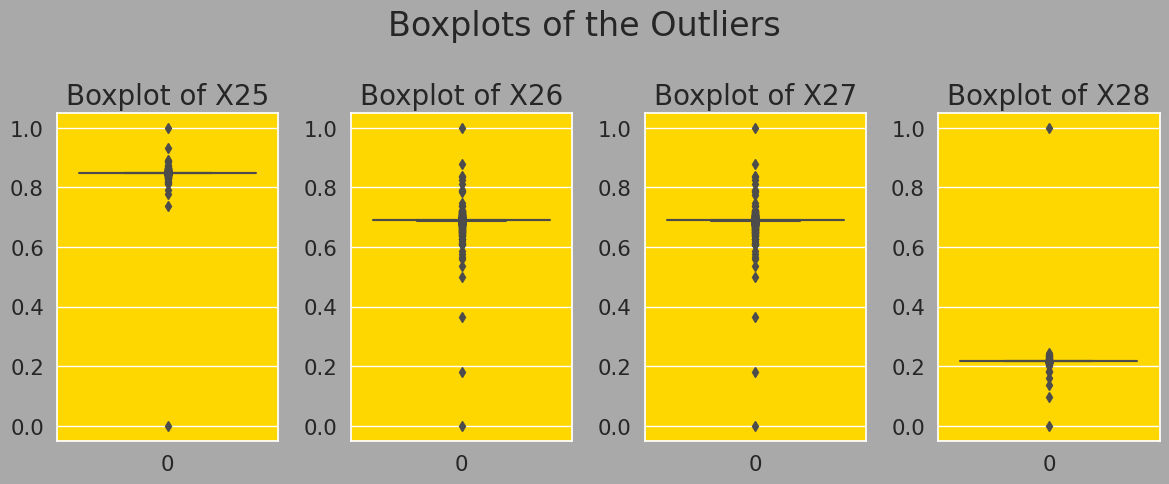

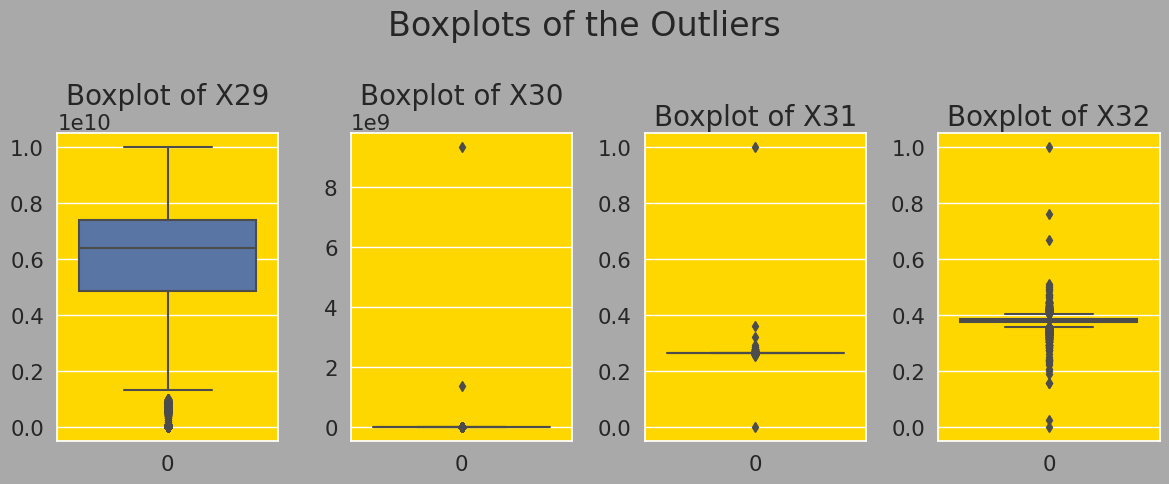

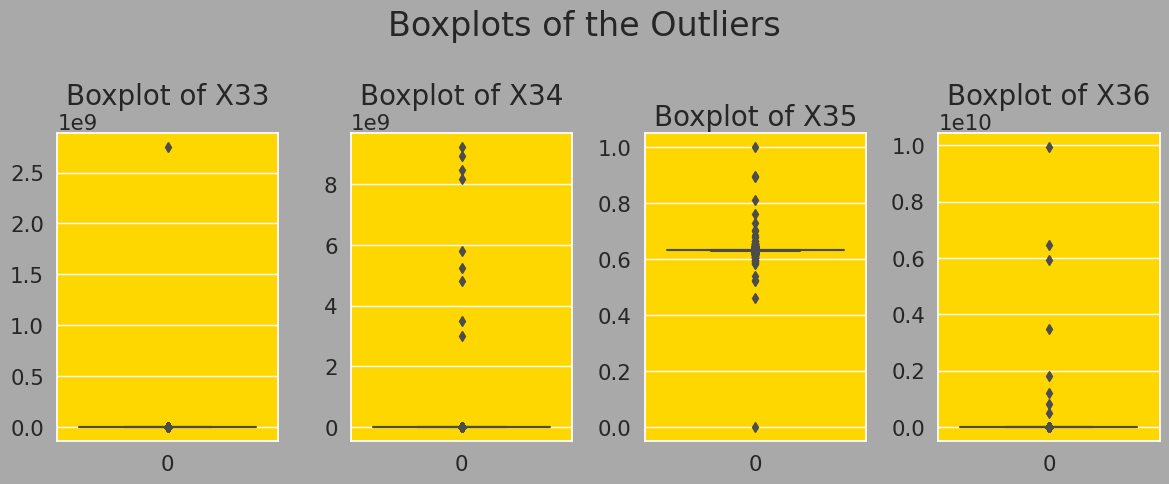

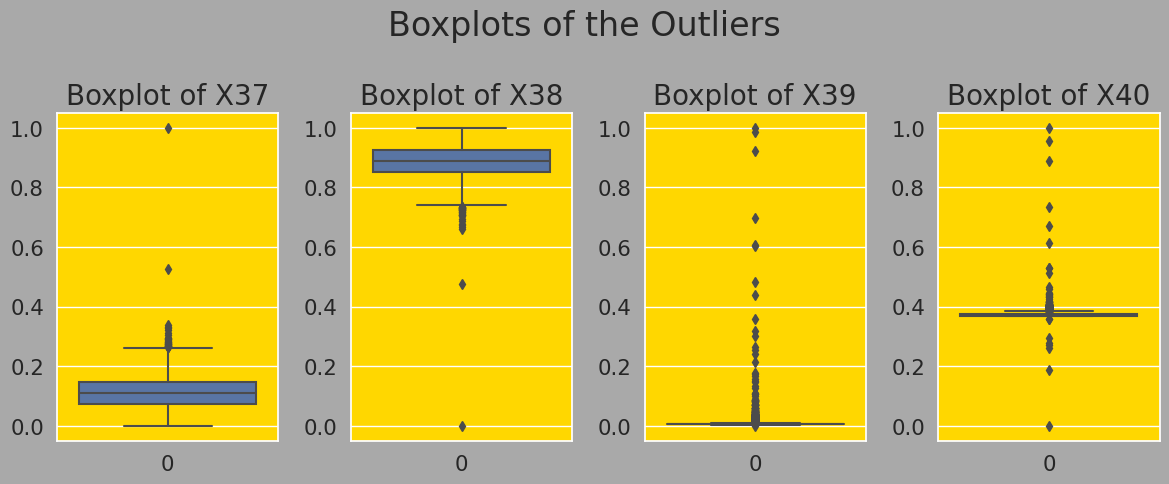

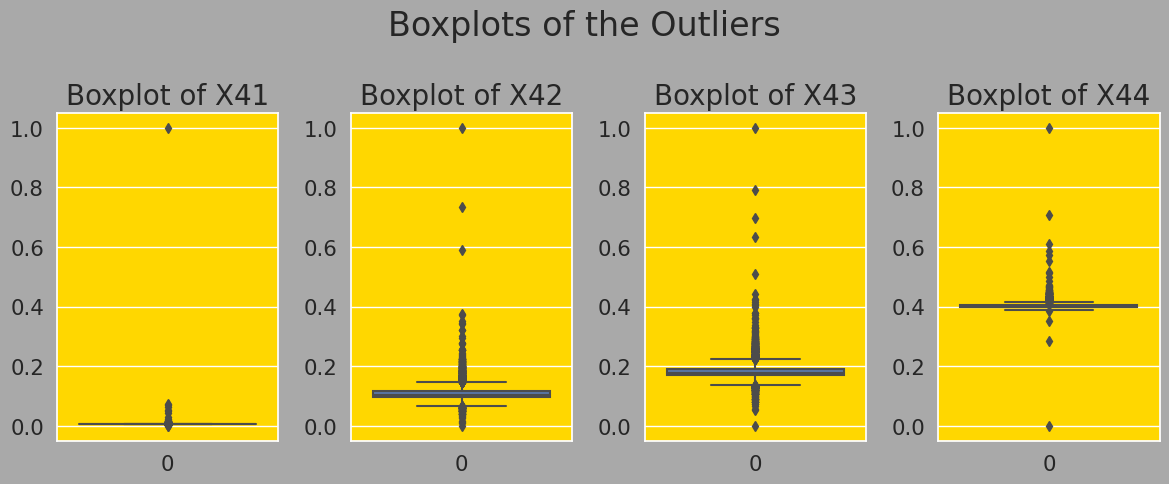

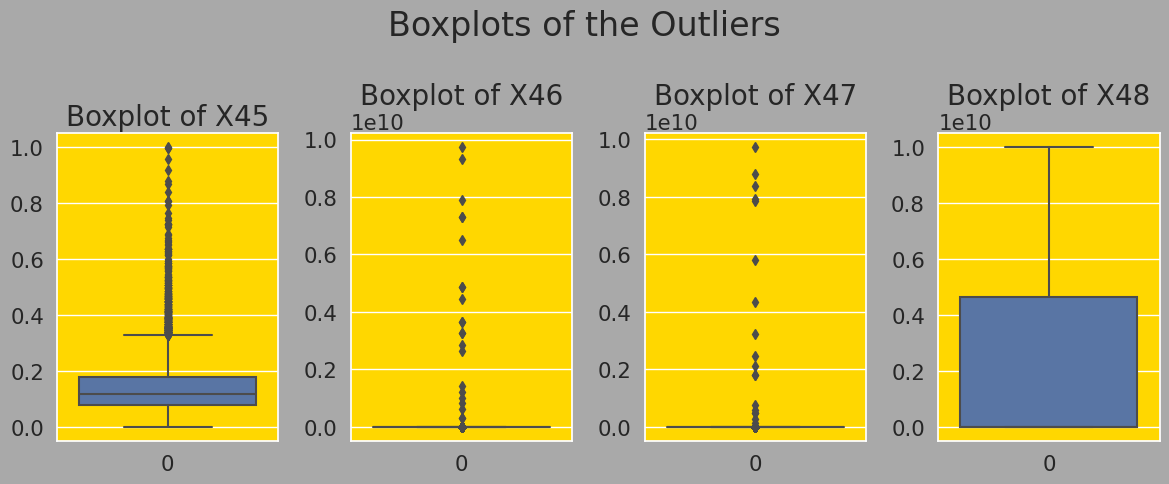

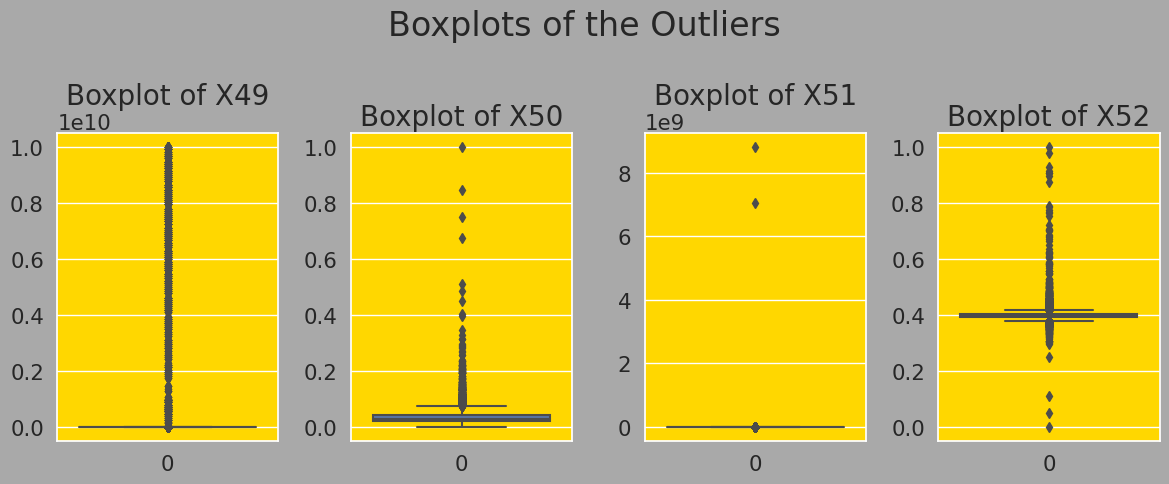

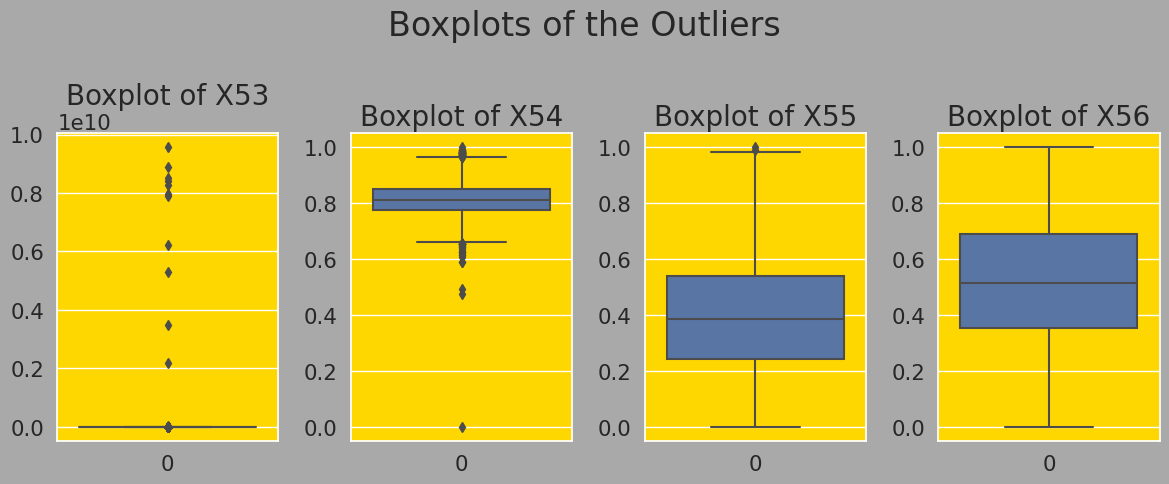

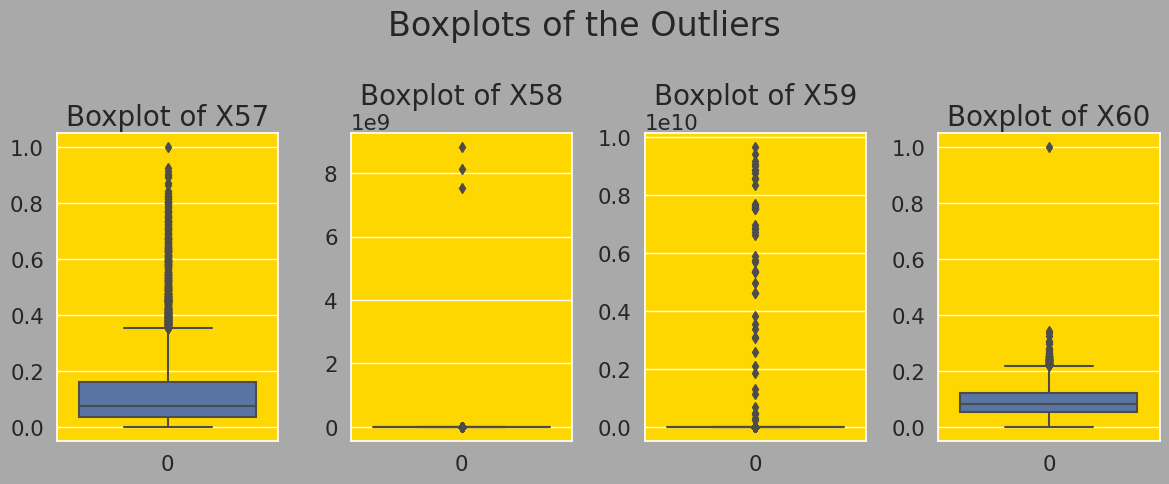

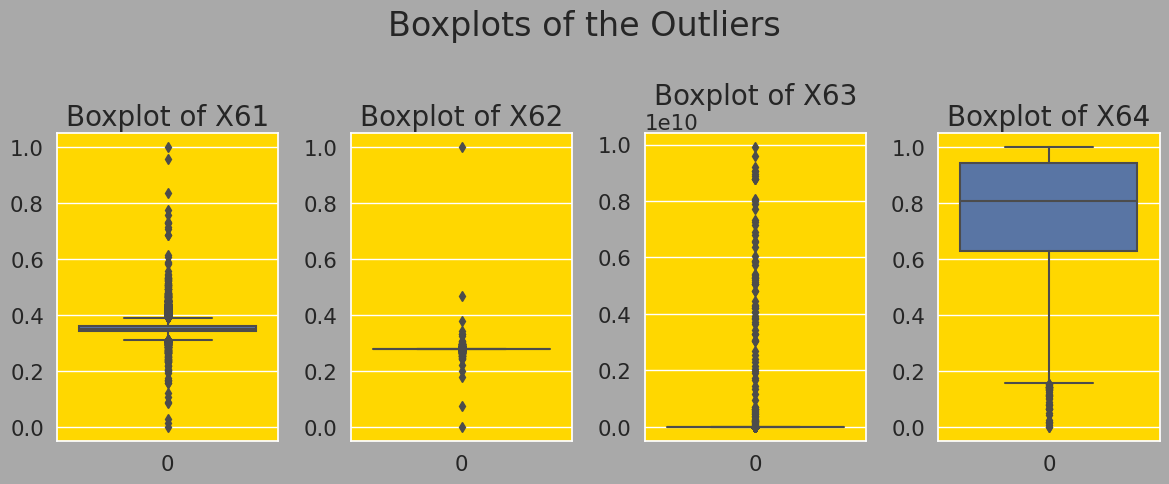

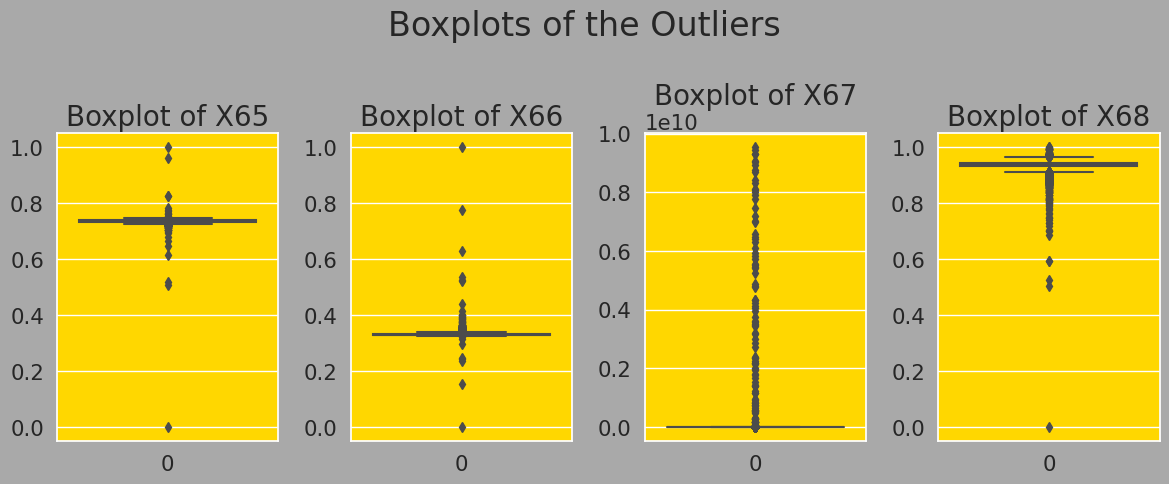

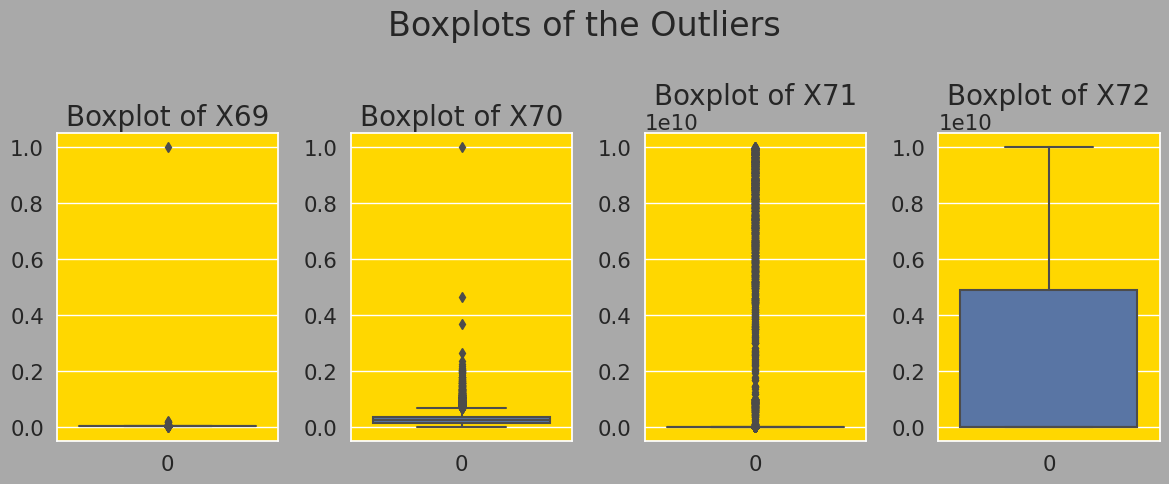

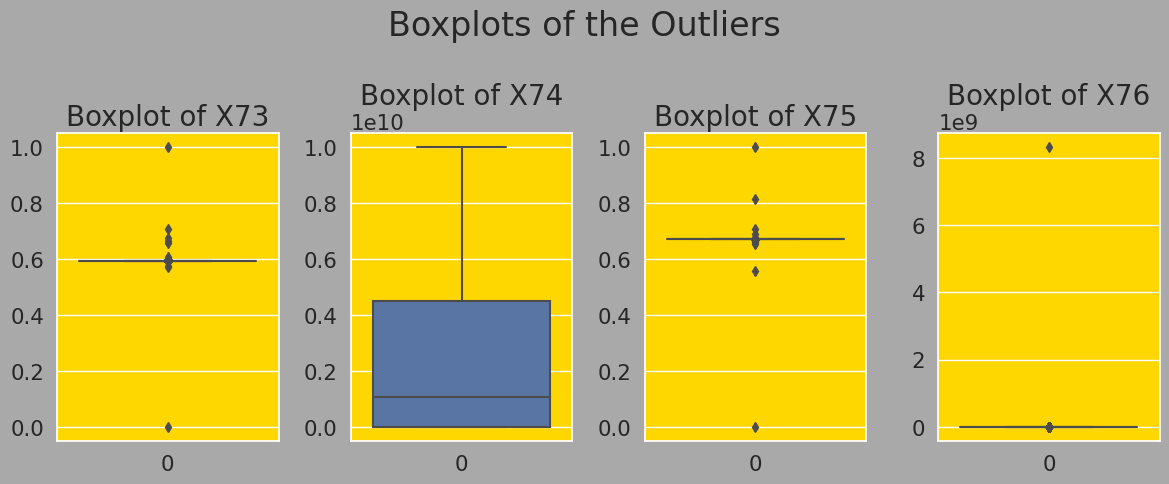

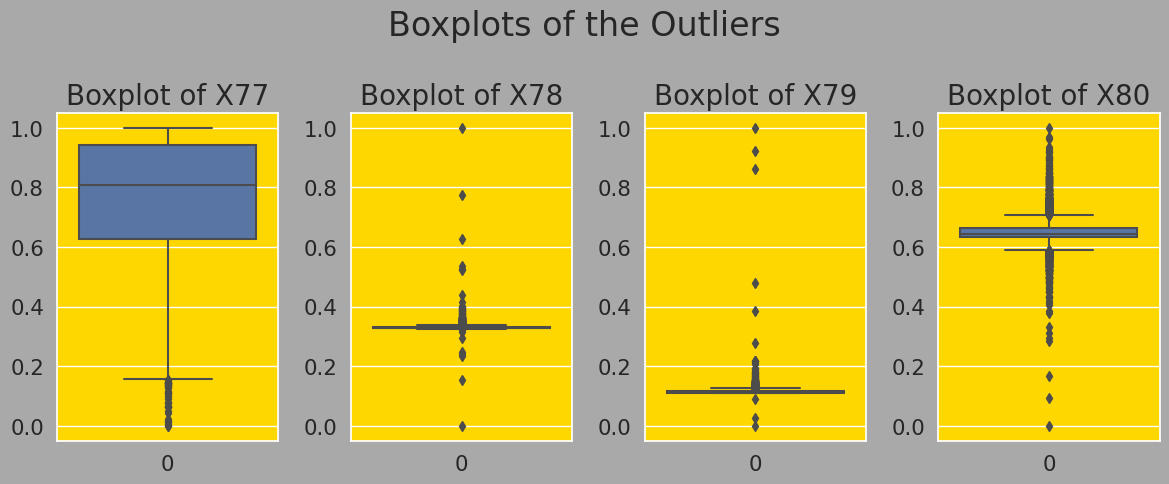

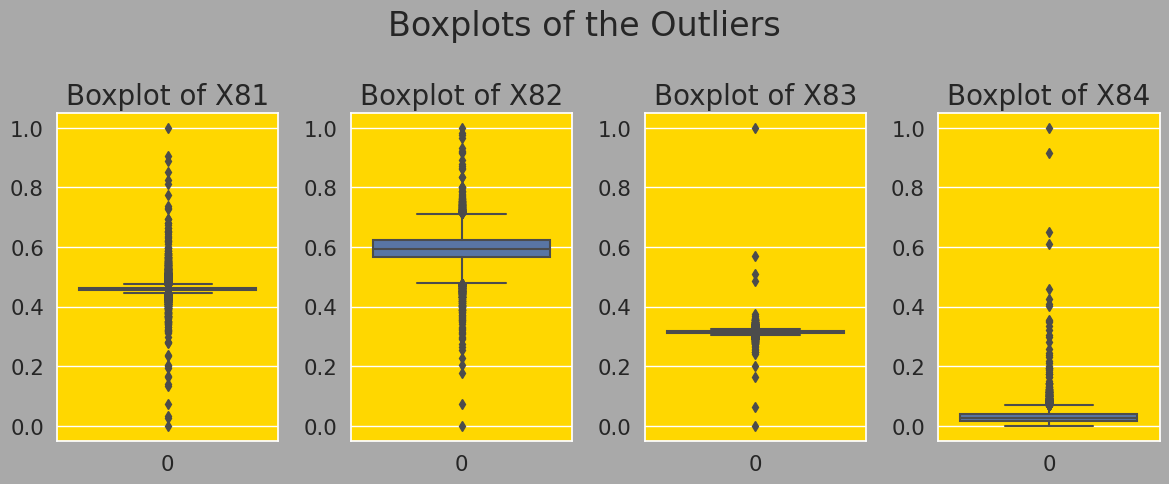

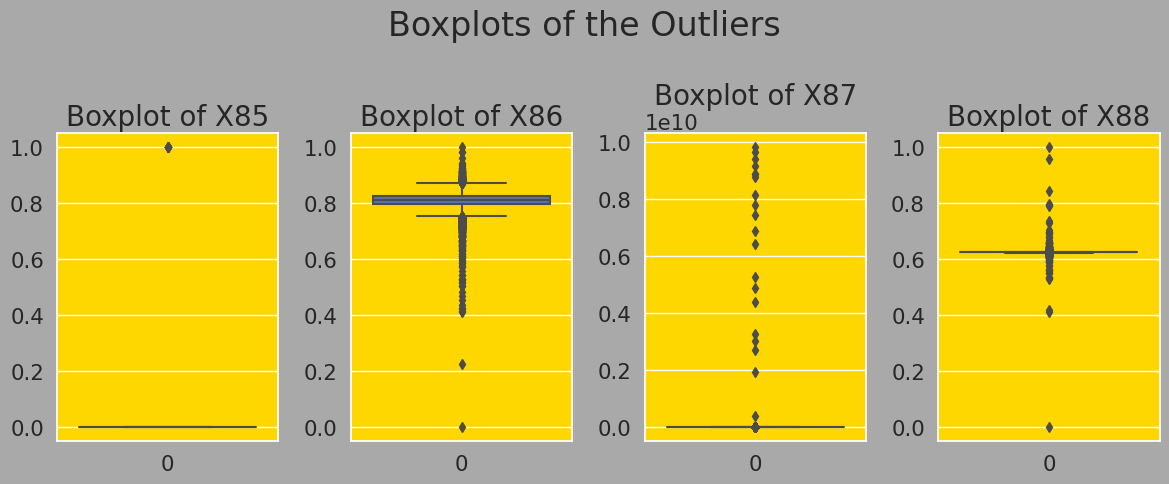

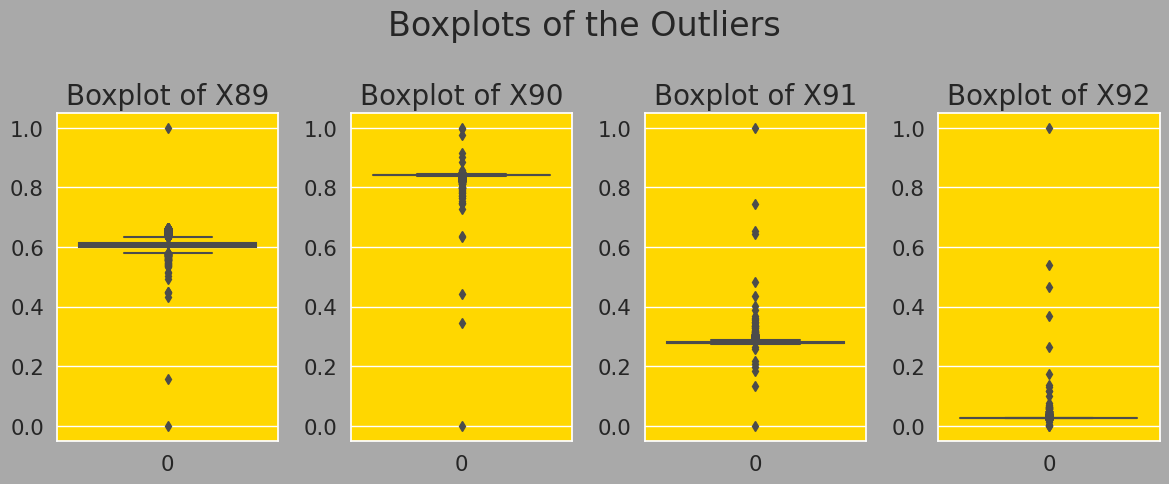

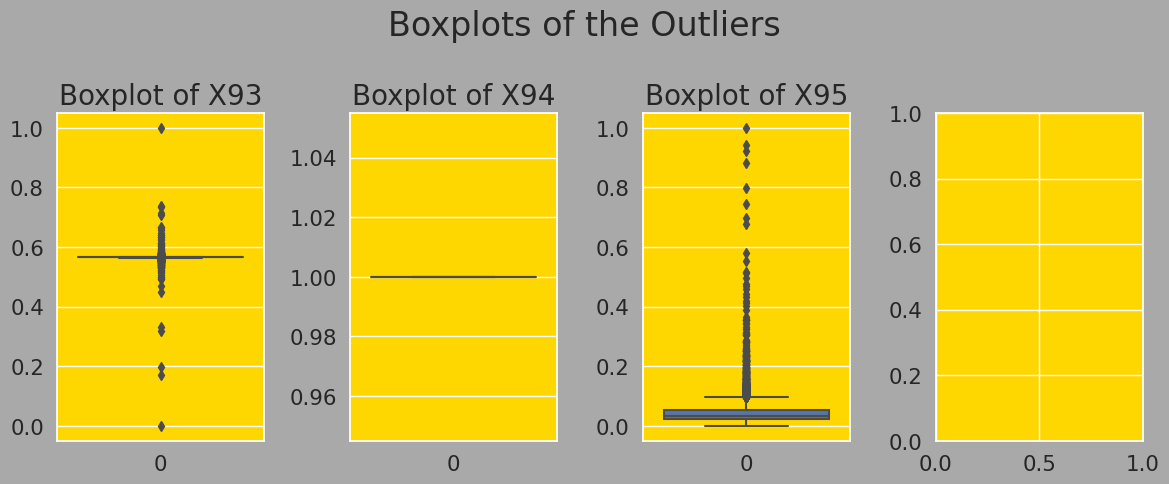

In [102]:
features = data.drop('Bankrupt?',axis=1).columns

for i in range(24):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(12,5))
    ax1 = sns.boxplot(data[features[i*4]],ax=ax1)
    ax1.set_title(f'Boxplot of X{i*4+1}',fontsize=20)
    ax1.set_facecolor('gold')
    ax2 = sns.boxplot(data[features[i*4+1]],ax=ax2)
    ax2.set_title(f'Boxplot of X{i*4+2}',fontsize=20)
    ax2.set_facecolor('gold')
    ax3 = sns.boxplot(data[features[i*4+2]],ax=ax3)
    ax3.set_title(f'Boxplot of X{i*4+3}',fontsize=20)
    ax3.set_facecolor('gold')
    if i < 23:
        ax4 = sns.boxplot(data[features[i*4+3]],ax=ax4)
        ax4.set_title(f'Boxplot of X{i*4+4}',fontsize=20)
        ax4.set_facecolor('gold')
    else:    
        ax4.set_facecolor('gold')
    
    fig.suptitle("Boxplots of the Outliers",fontsize=24)    
    
    plt.tight_layout()
    fig.set_facecolor('darkgrey')

X variable이 더 많은 outliers 가진 것을 확인함

**2-3 correlation**

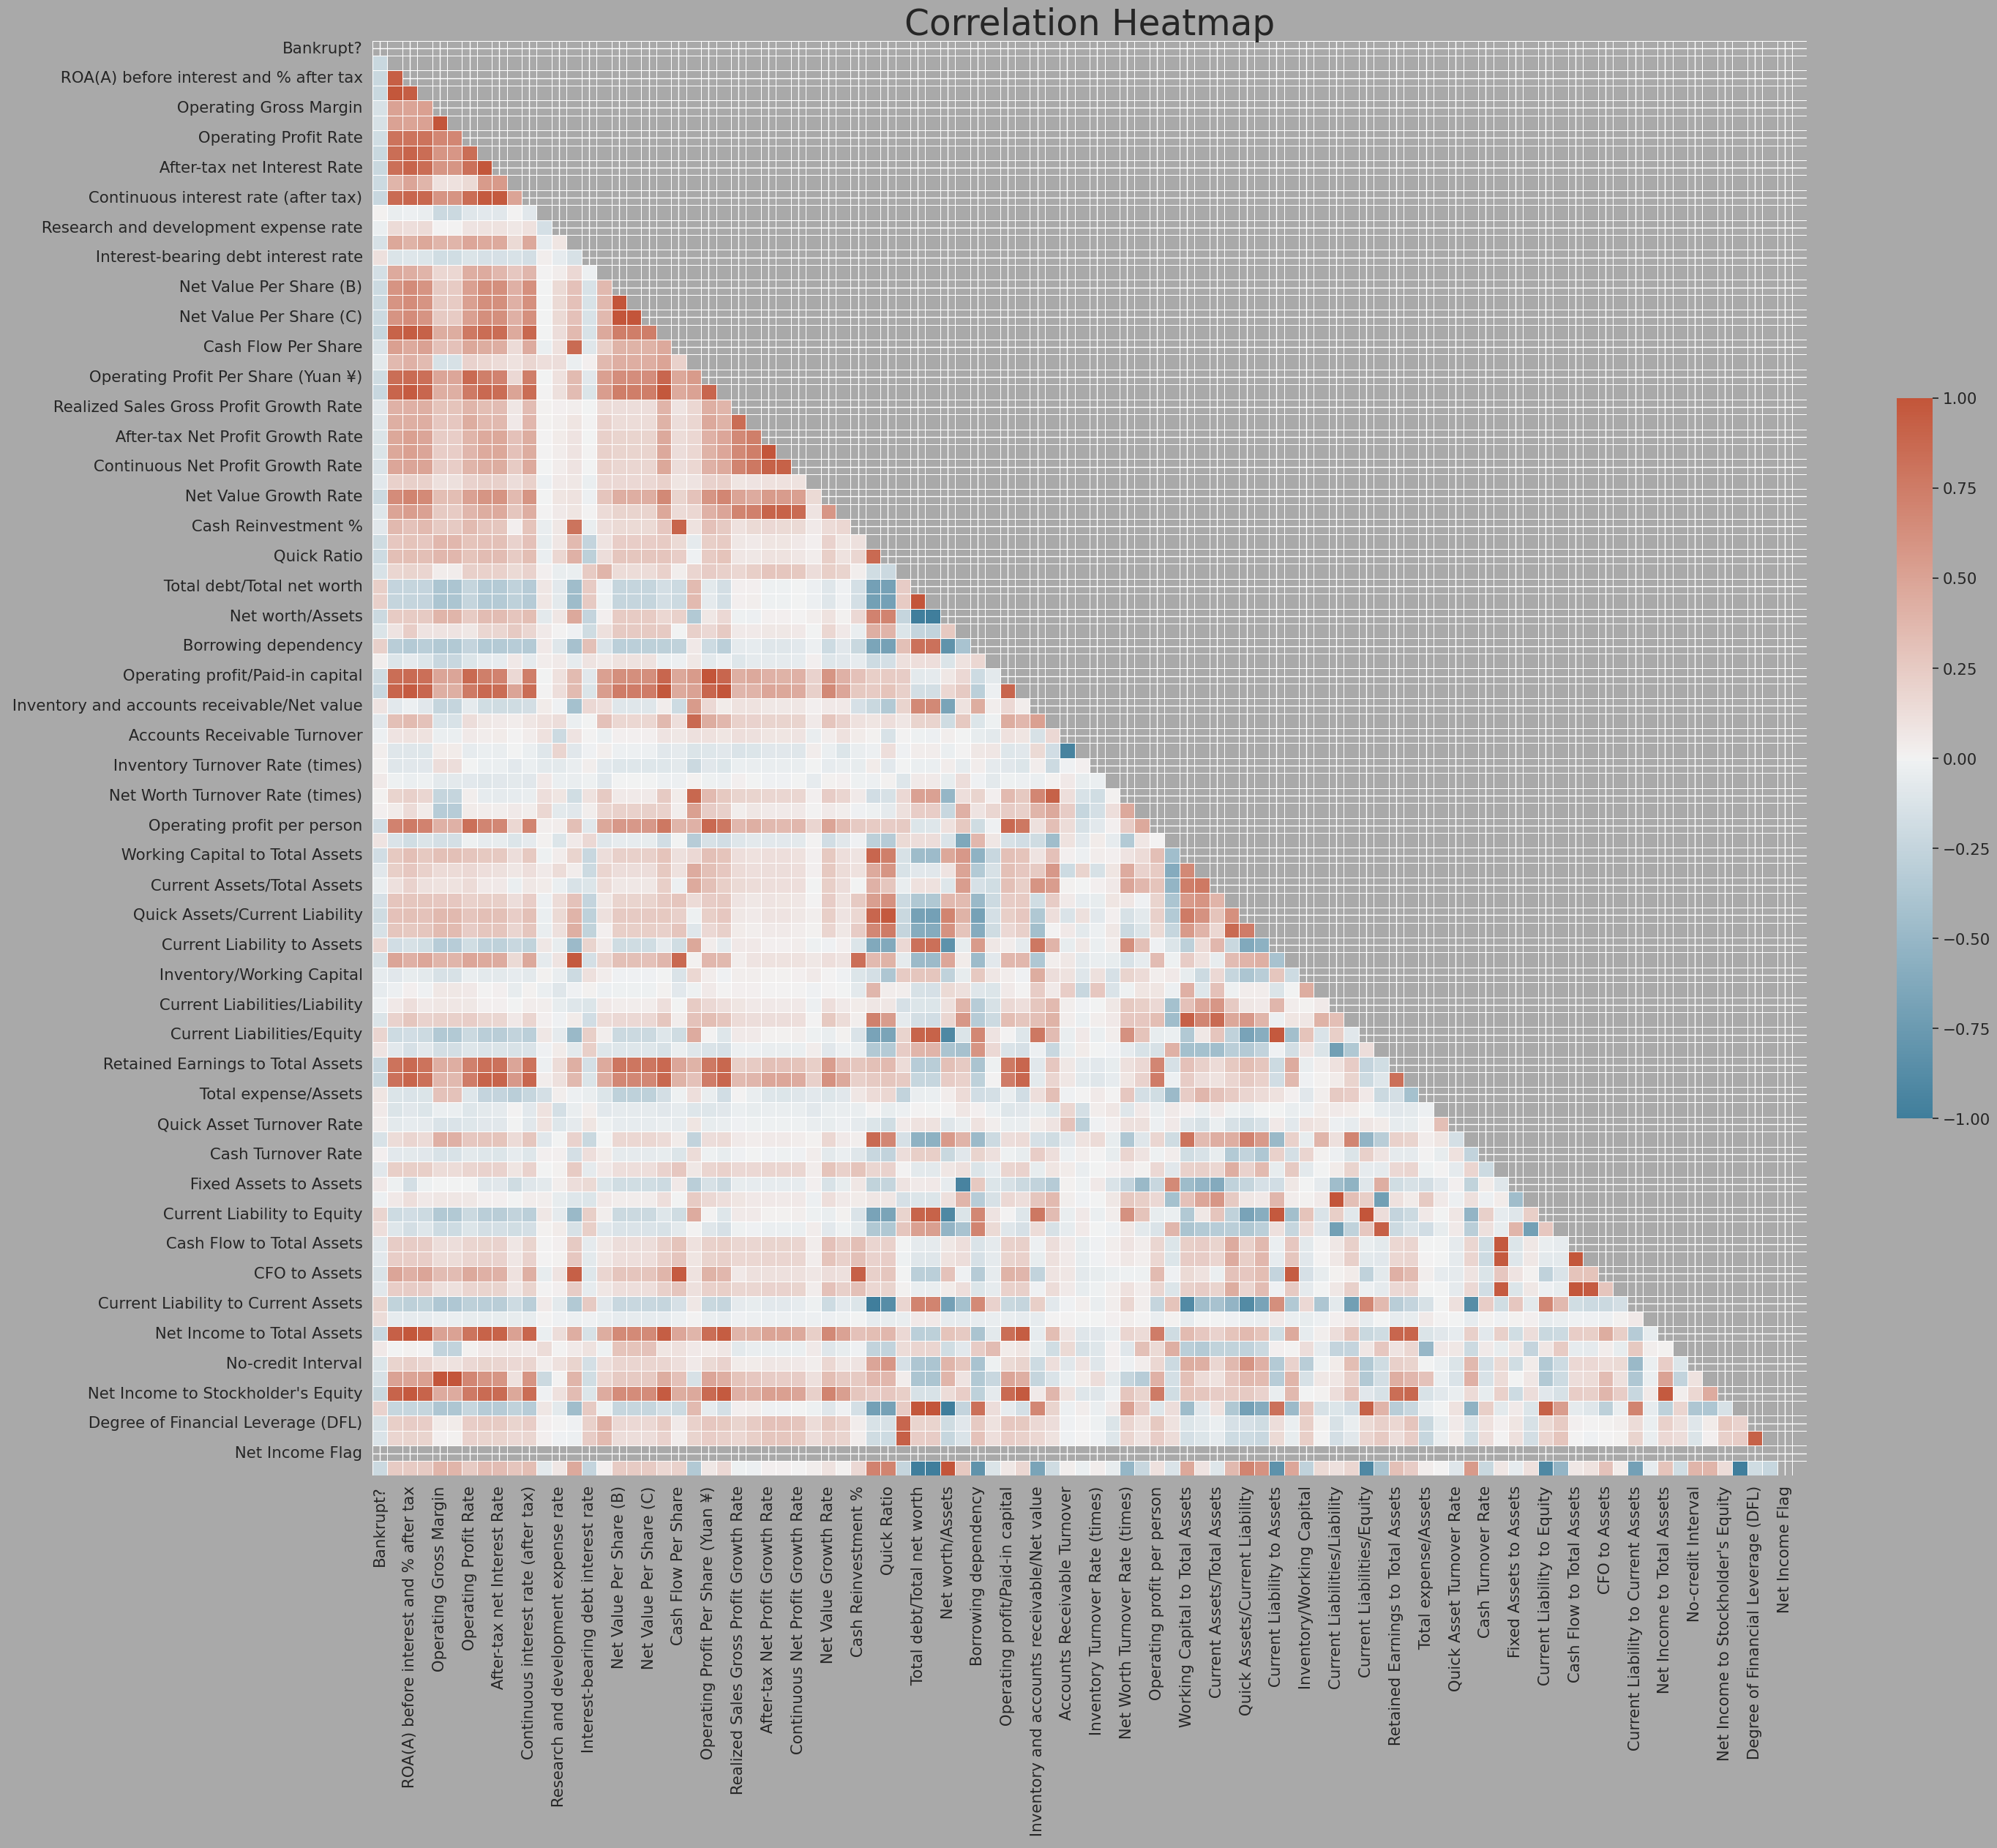

In [103]:
f,ax = plt.subplots(figsize=(30, 25))

mat = data.corr('spearman')
mask = np.triu(np.ones_like(mat,dtype=bool))
cmap = sns.diverging_palette(230,20,as_cmap=True)

sns.heatmap(mat,mask=mask,cmap=cmap,vmax=1,center=0,square=True,linewidths=.5,cbar_kws={"shrink":.5})

plt.title('Correlation Heatmap',fontsize=35)

plt.tight_layout()
plt.gcf().patch.set_facecolor('darkgrey')
plt.gca().set_facecolor('darkgrey')

plt.show()

variable 사이에 강한 correlation이 있음을 확인. R>0.9 혹은 R<-0.9 인 feature 확인하기

In [104]:
list1 = features
list2 = features
list_int = []
count = 1

for col1 in list1:
    list_int.append(col1)
    for col2 in list2:
        if col2 not in list_int:
            R_corr = data.corr().loc[col1,col2]
            if R_corr > 0.9 or R_corr < -0.9:
                print(count,'.  ',col1,' -- ',col2,';  R = {:.3f}'.format(R_corr))   
                count += 1 

1 .    ROA(C) before interest and depreciation before interest  --   ROA(A) before interest and % after tax ;  R = 0.940
2 .    ROA(C) before interest and depreciation before interest  --   ROA(B) before interest and depreciation after tax ;  R = 0.987
3 .    ROA(A) before interest and % after tax  --   ROA(B) before interest and depreciation after tax ;  R = 0.956
4 .    ROA(A) before interest and % after tax  --   Net Income to Total Assets ;  R = 0.962
5 .    ROA(B) before interest and depreciation after tax  --   Net Income to Total Assets ;  R = 0.912
6 .    Operating Gross Margin  --   Realized Sales Gross Margin ;  R = 1.000
7 .    Operating Gross Margin  --   Gross Profit to Sales ;  R = 1.000
8 .    Realized Sales Gross Margin  --   Gross Profit to Sales ;  R = 1.000
9 .    Operating Profit Rate  --   Pre-tax net Interest Rate ;  R = 0.916
10 .    Operating Profit Rate  --   Continuous interest rate (after tax) ;  R = 0.916
11 .    Pre-tax net Interest Rate  --   After-tax net

피어슨 계수 R의 값이 높은 각 feature 쌍의 요소 중 하나 이상을 삭제해야 함

# **2. 데이터 전처리 **

outliers capping 해주기

In [105]:
# Function for outliers capping
def outlier_imputer(data,features):
    
    data_out = data.copy()
    
    for column in features:        
        
        # First define the first and third quartiles
        Q1 = data_out[column].quantile(0.25)
        Q3 = data_out[column].quantile(0.75)
        # Define the inter-quartile range
        IQR = Q3 - Q1
        # ... and the lower/higher threshold values
        lowerL = (Q1 - 1.5 * IQR)
        higherL = (Q3 + 1.5 * IQR)
        
        # Impute 'left' outliers
        data_out.loc[data_out[column] < lowerL,column] = lowerL
        # Impute 'right' outliers
        data_out.loc[data_out[column] > higherL,column] = higherL
        
    return data_out 

# Outliers capping is carried out on the float columns only
data_in     = data.select_dtypes(include='float')
features_in = data_in.columns

capped_data = outlier_imputer(data_in,features_in)  

In [106]:
# Integer-type columns are concatenated to the capped dataset
data_int = data.select_dtypes(include='int')

data2 = pd.concat([capped_data,data_int],axis=1)

data2.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?,Liability-Assets Flag,Net Income Flag
0,0.387973,0.455122,0.442034,0.601457,0.601457,0.998969,0.797096,0.809075,0.303288,0.781314,1.256970e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.178548,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000353,0.263100,0.363725,0.002259,0.001208,0.629951,0.018673,0.207576,0.792424,0.005024,0.385425,0.006362,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820930e-04,0.000117,0.032903,0.034164,0.392913,0.031370,0.672775,0.166673,0.190643,0.004094,0.001997,0.000147,0.147308,0.334015,0.276920,0.001036,0.676269,0.726190,0.338662,0.022515,0.910524,0.002022,0.064856,0.000913,6.550000e+09,0.593833,4.580000e+08,0.671568,0.424206,0.676269,0.338662,0.126365,0.637555,0.458609,0.520382,0.312905,0.068886,0.752193,0.009219,0.622879,0.601453,0.836752,0.288207,0.026608,0.564309,0.016469,1,0,1
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897850e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.631895,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,0.008781,0.025484,0.006889,0.391590,0.0123

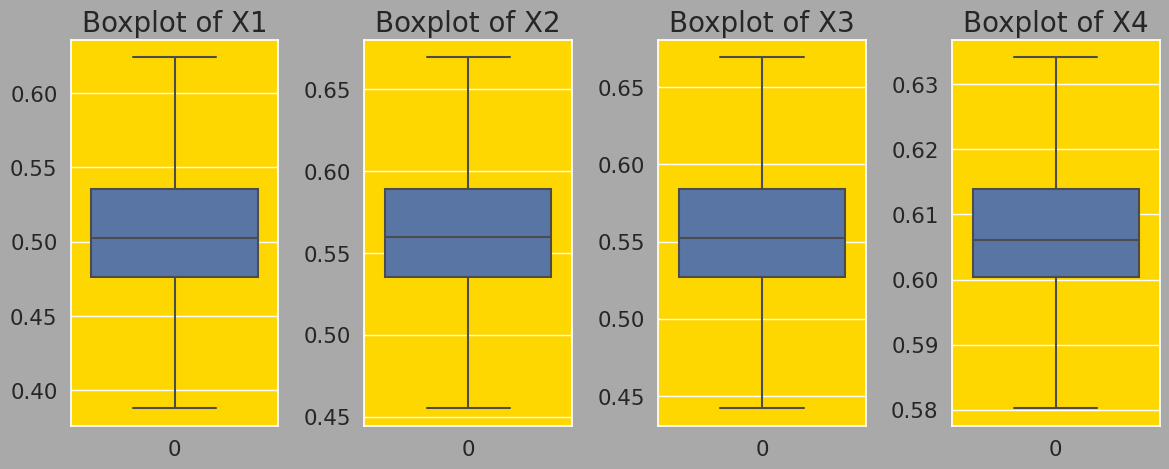

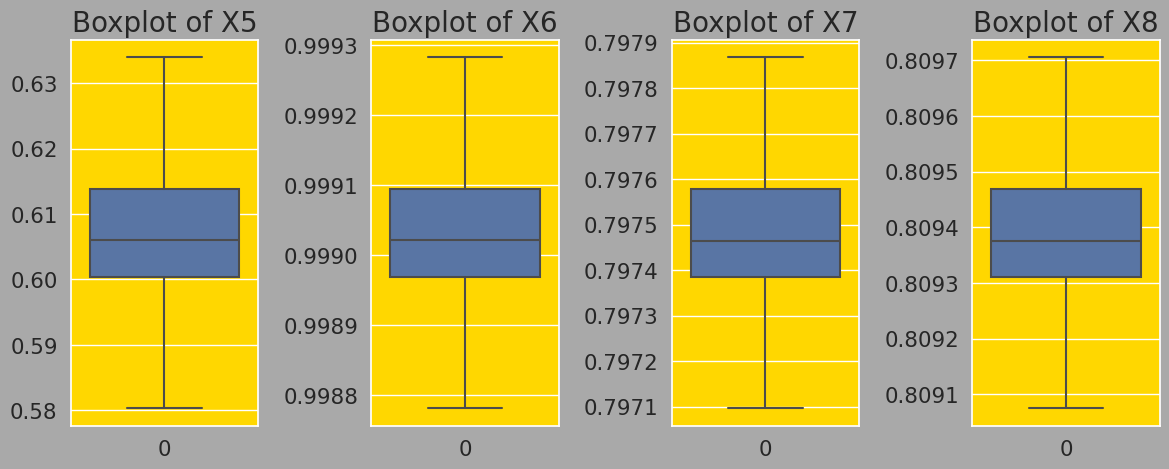

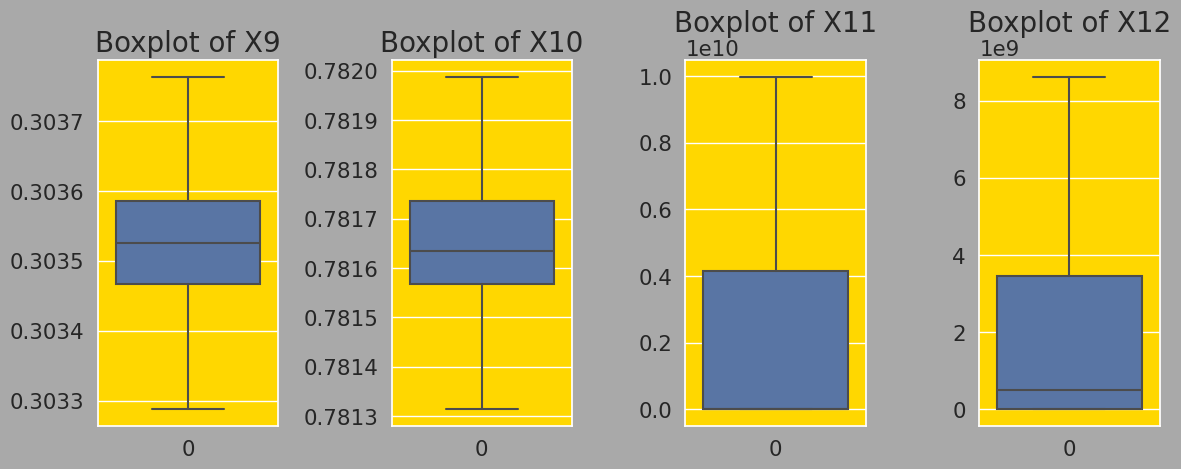

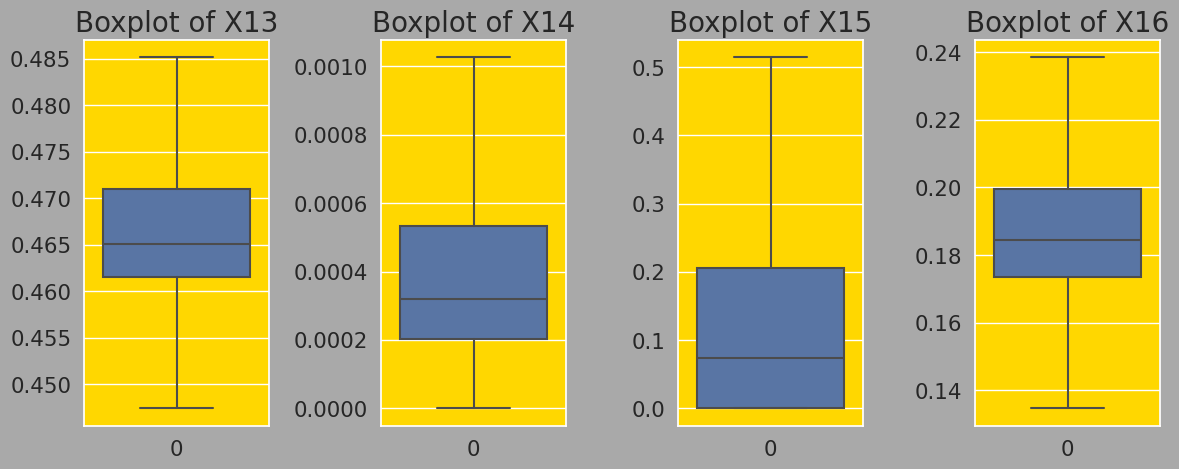

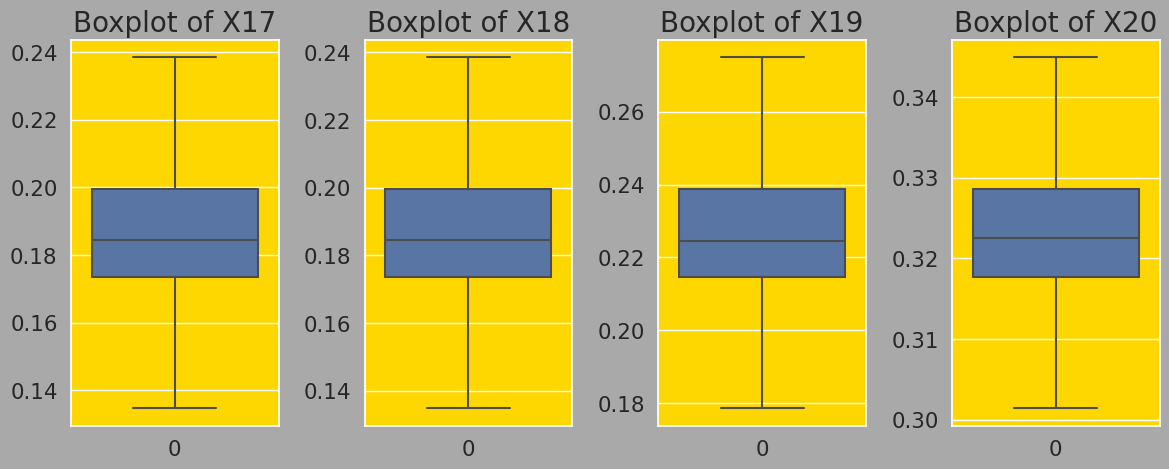

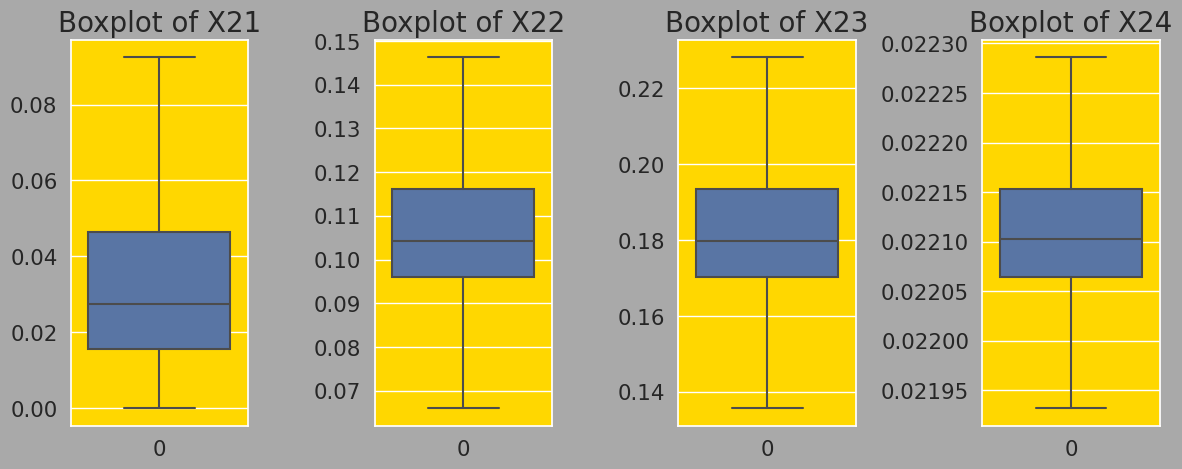

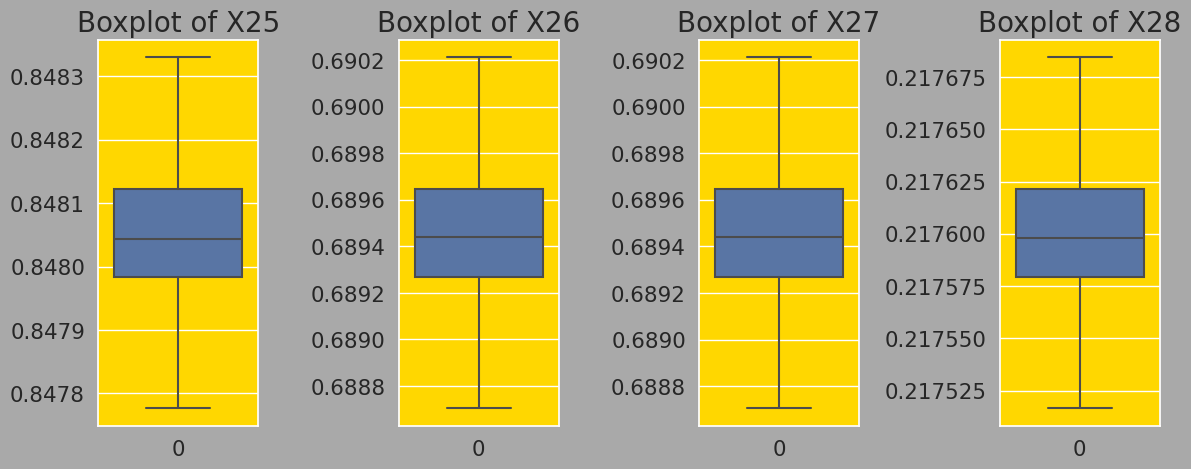

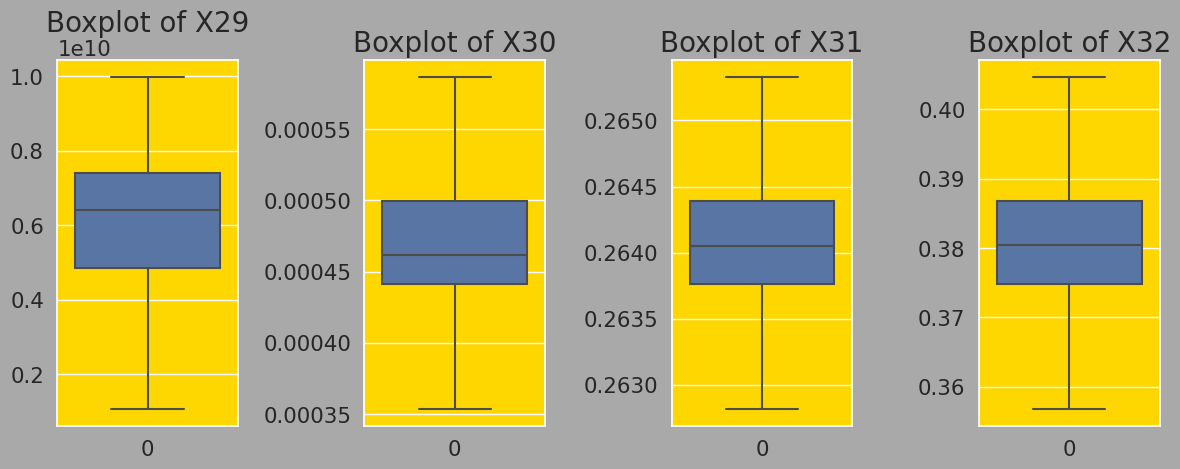

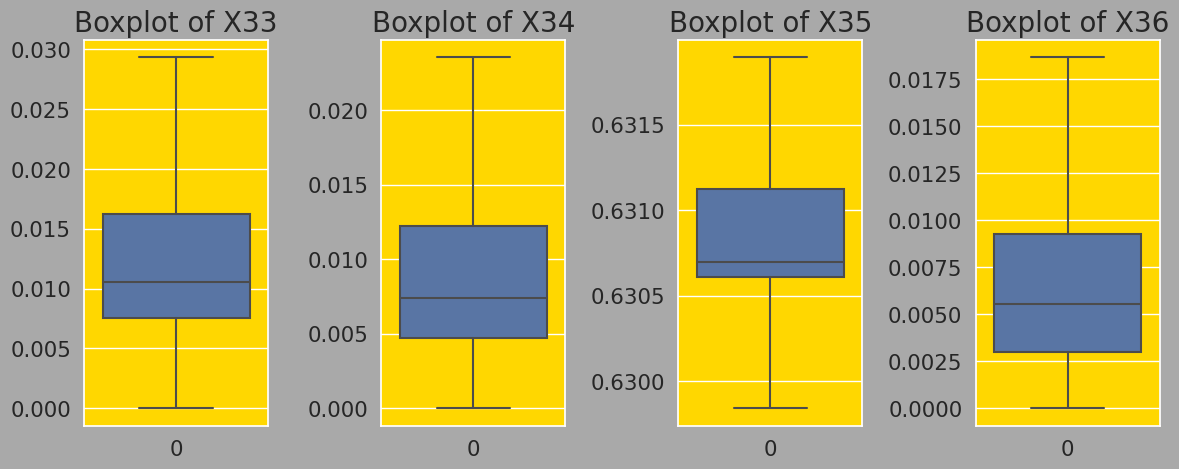

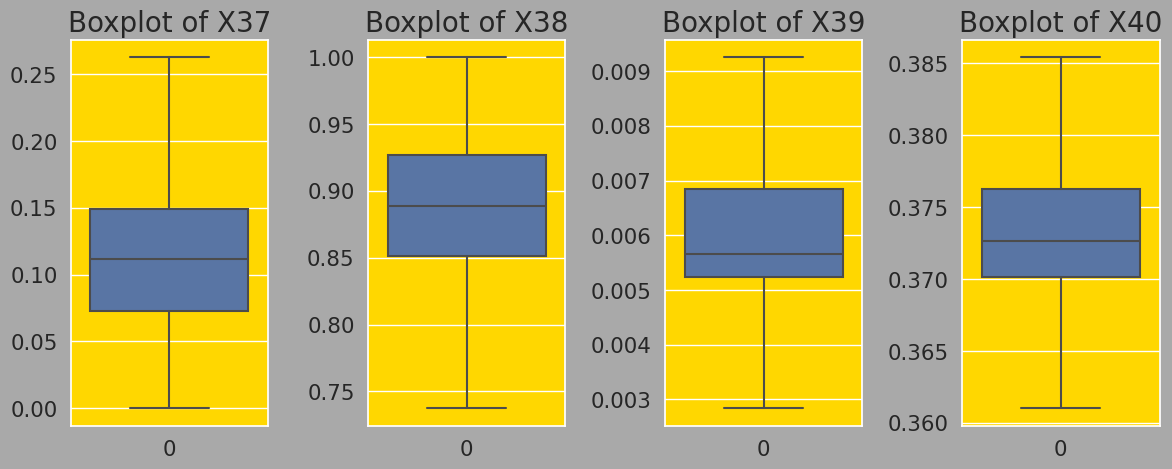

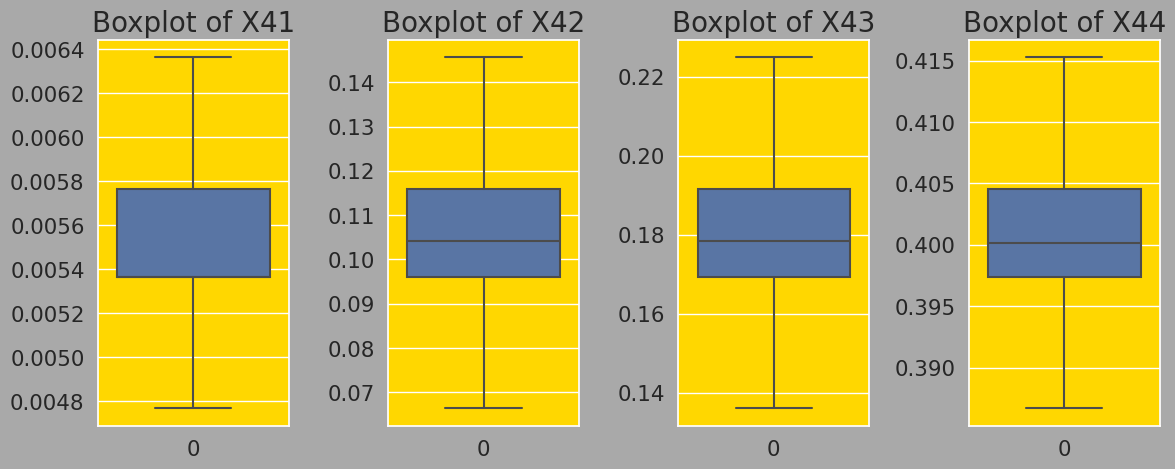

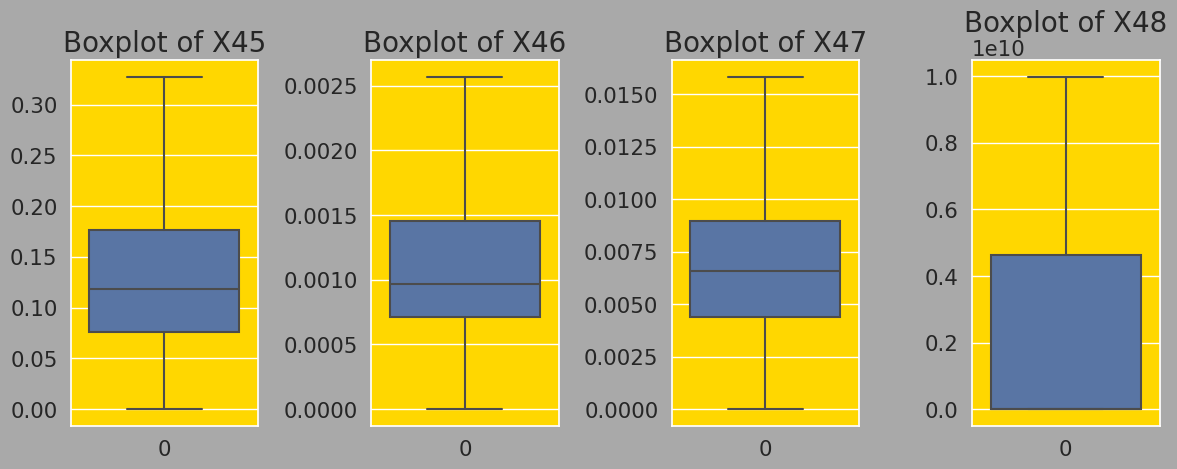

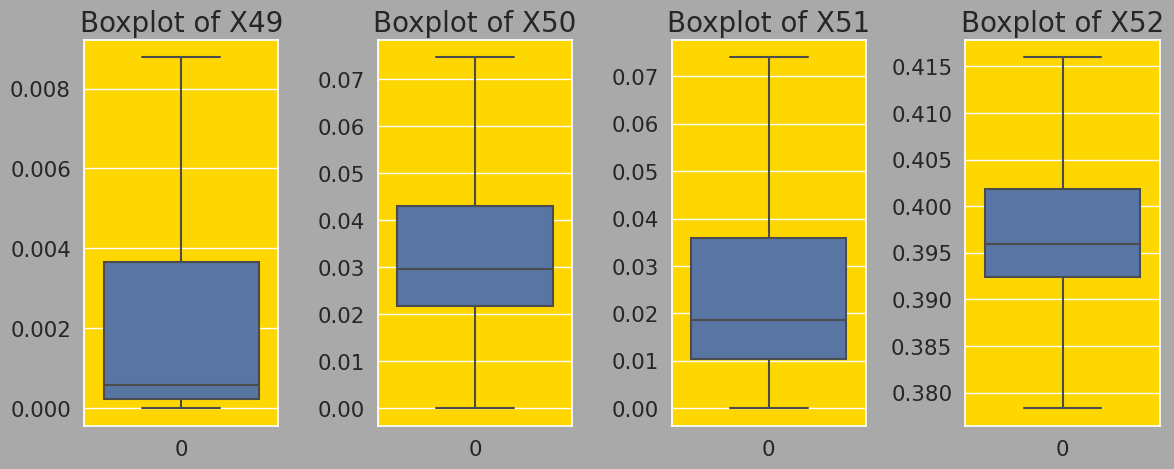

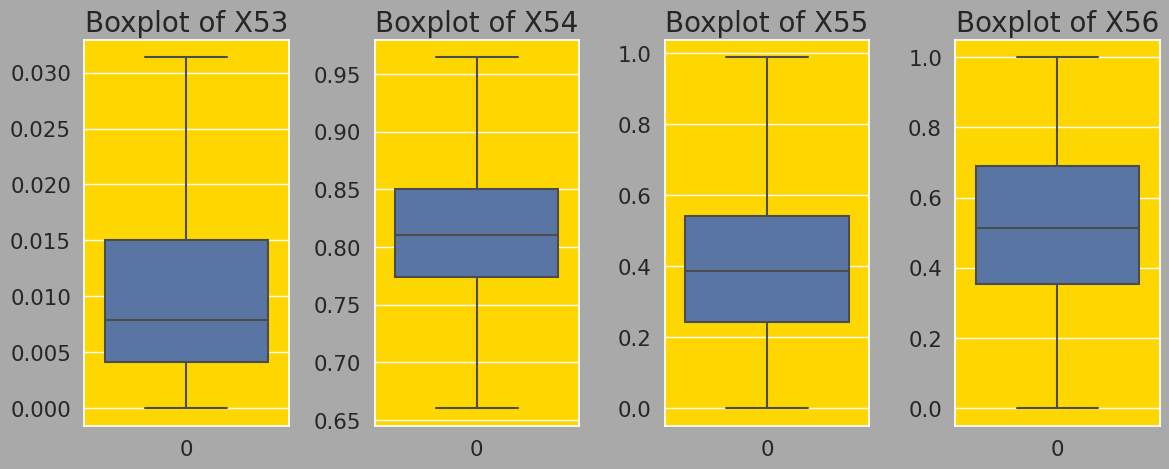

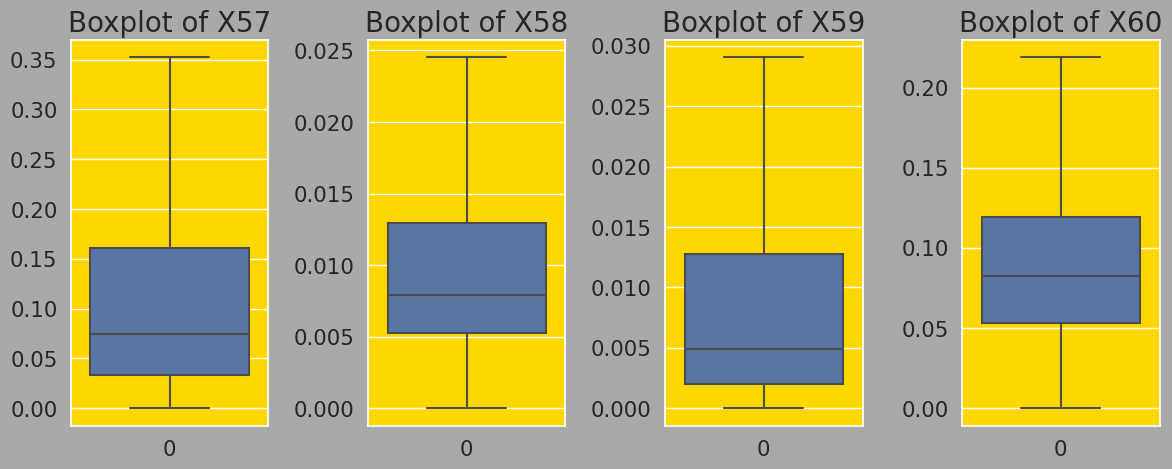

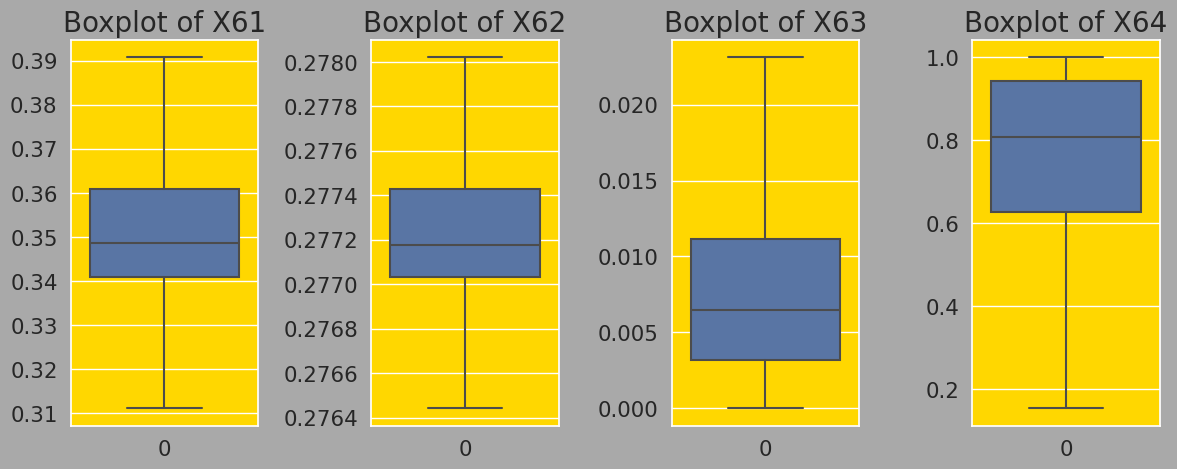

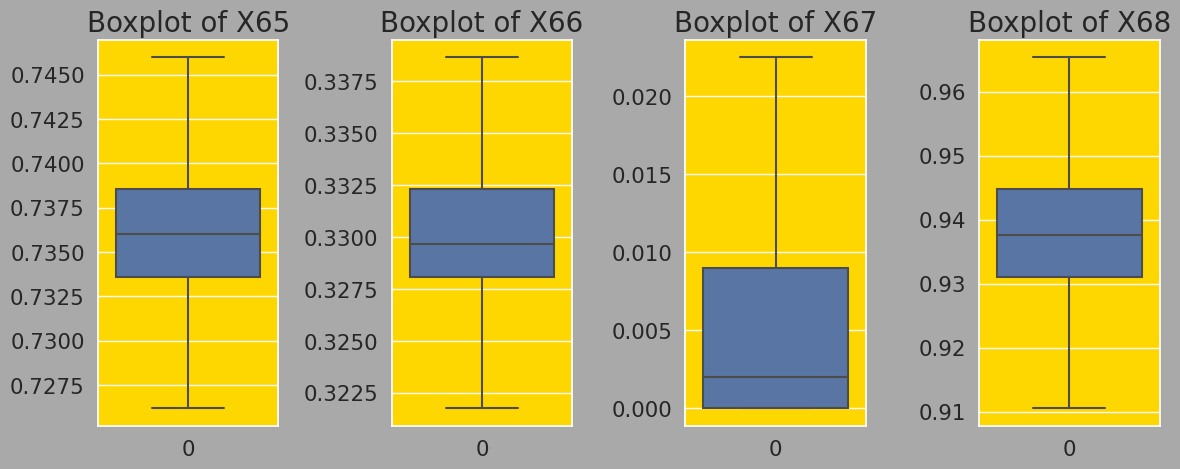

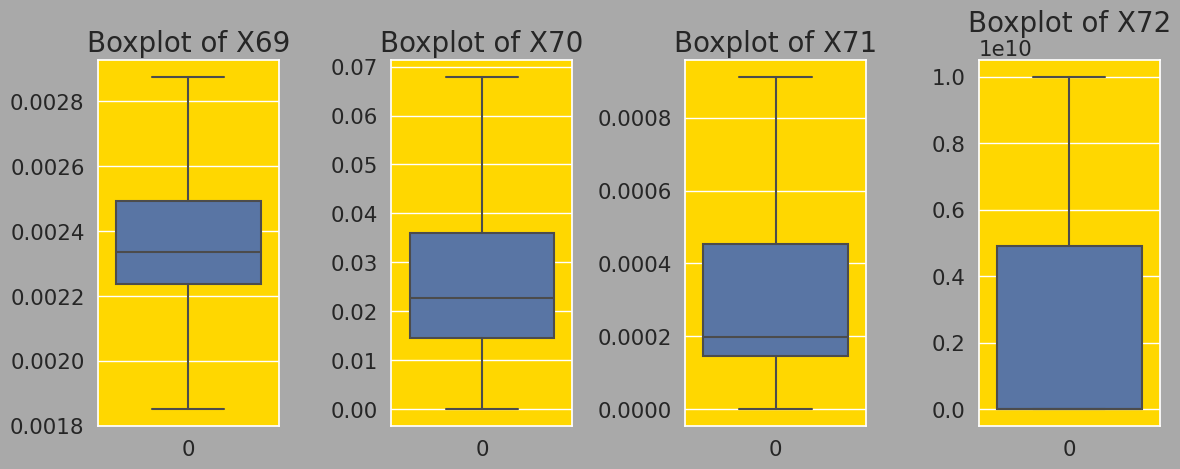

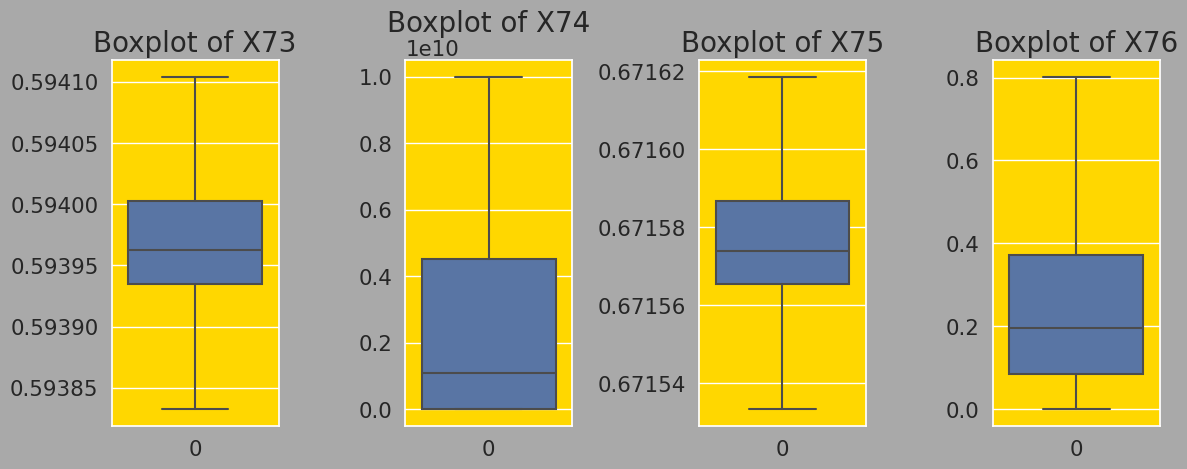

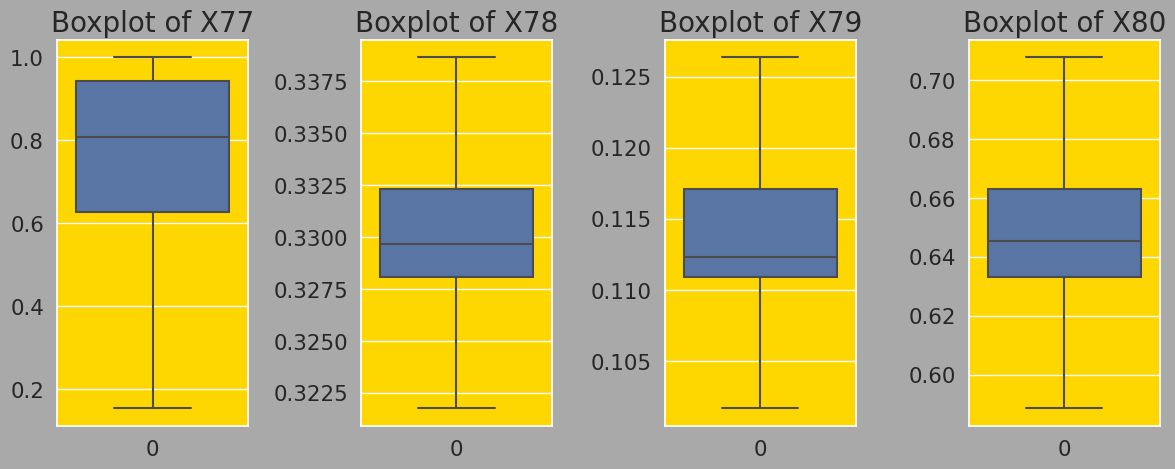

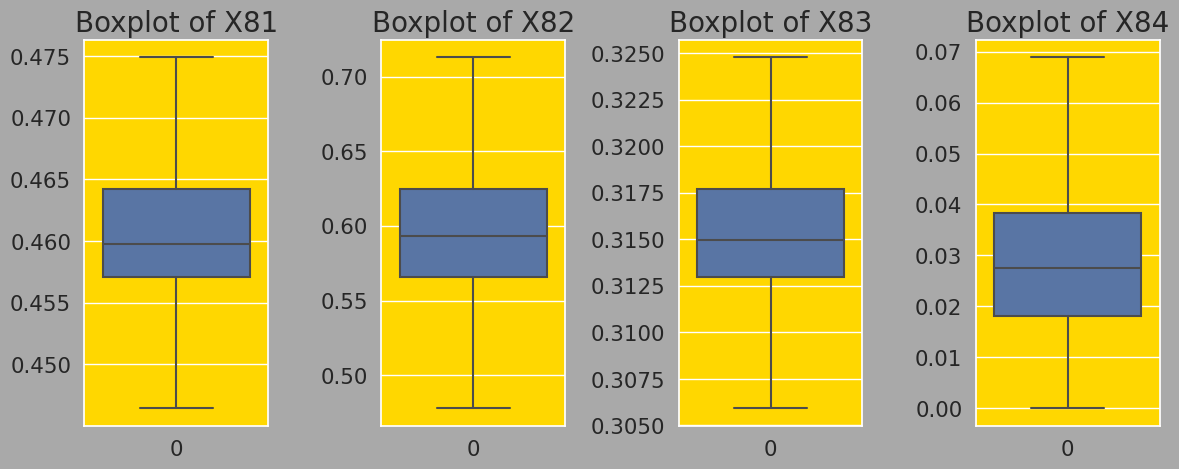

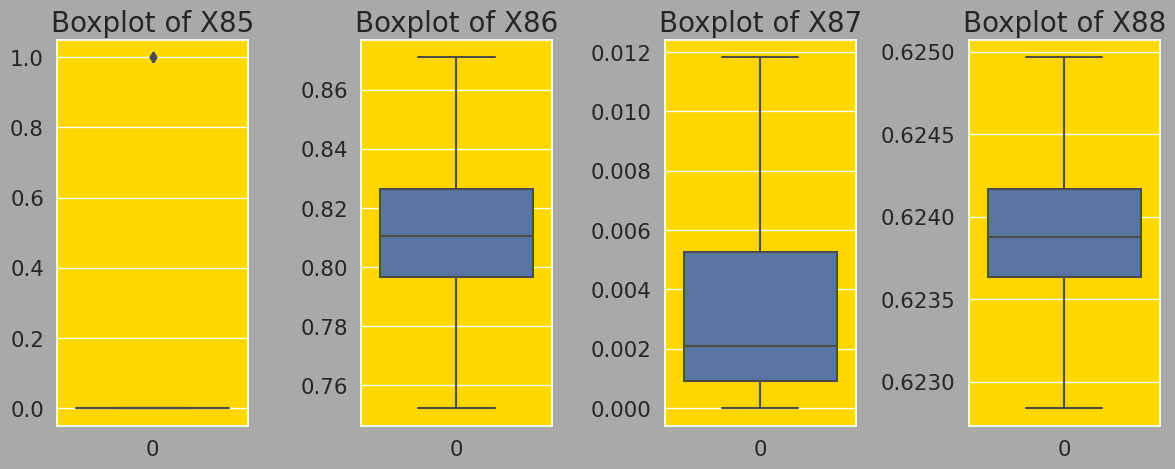

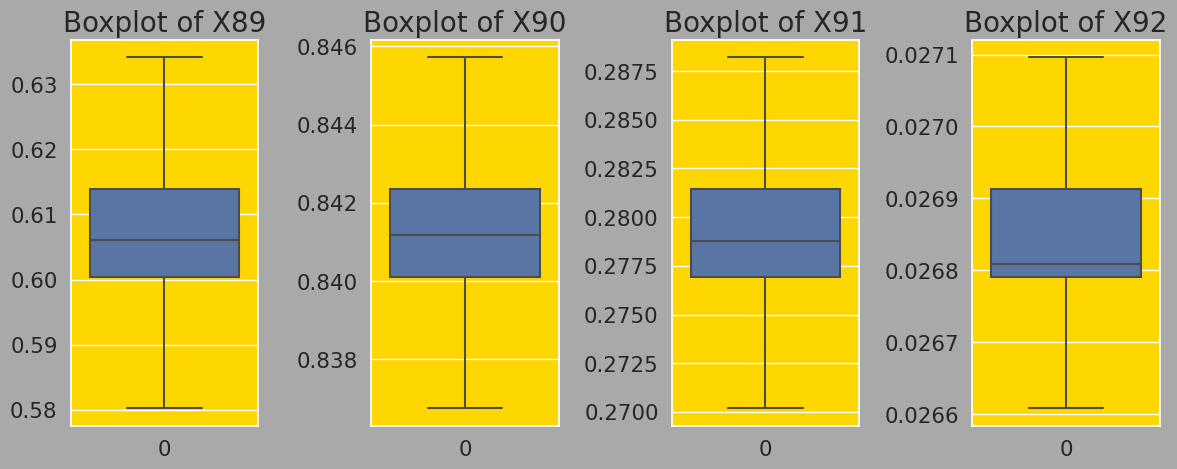

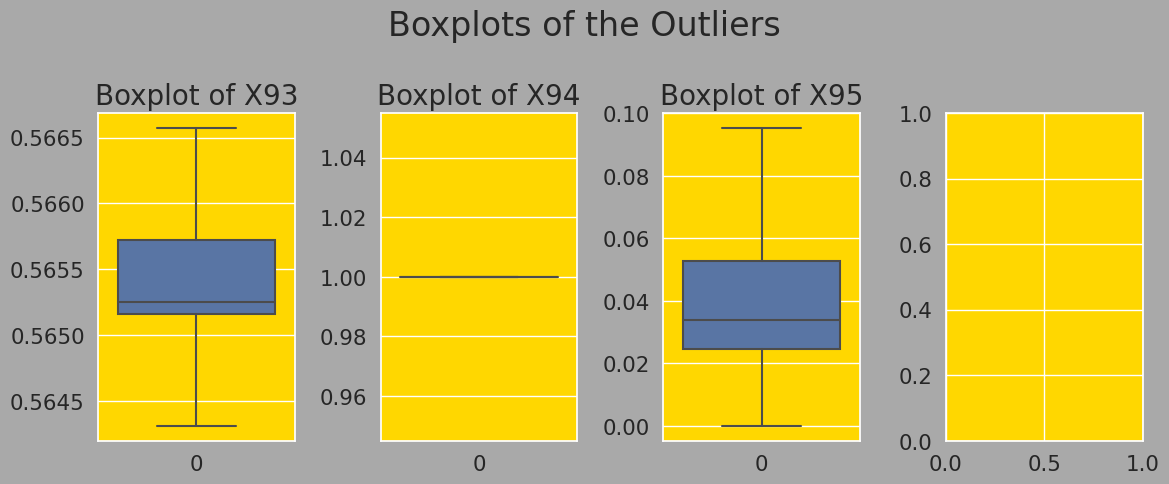

In [107]:
for i in range(24):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(12,5))
    ax1 = sns.boxplot(data2[features[i*4]],ax=ax1)
    ax1.set_title(f'Boxplot of X{i*4+1}',fontsize=20)
    ax1.set_facecolor('gold')
    ax2 = sns.boxplot(data2[features[i*4+1]],ax=ax2)
    ax2.set_title(f'Boxplot of X{i*4+2}',fontsize=20)
    ax2.set_facecolor('gold')
    ax3 = sns.boxplot(data2[features[i*4+2]],ax=ax3)
    ax3.set_title(f'Boxplot of X{i*4+3}',fontsize=20)
    ax3.set_facecolor('gold')
    if i < 23:
        ax4 = sns.boxplot(data2[features[i*4+3]],ax=ax4)
        ax4.set_title(f'Boxplot of X{i*4+4}',fontsize=20)
        ax4.set_facecolor('gold')
    else:    
        ax4.set_facecolor('gold')
        fig.suptitle("Boxplots of the Outliers",fontsize=24)    
    
    plt.tight_layout()
    fig.set_facecolor('darkgrey')

**2-1. 리샘플링 해주기**

우선 X, Y 변수마다 정의해주기

In [108]:
X = data2.drop('Bankrupt?',axis=1)
y = data2['Bankrupt?']

train-test splitting 하기

In [109]:
# Train-test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

Oversampling

 It consists in copying the rows of the dataset with a target variable value belonging to the minority class, so that their number is the same as that of the rows with a target variable value belonging to the majority class.

In [110]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# Balancing the data
X_overSampled,y_overSampled = smote.fit_resample(X_train,y_train)

In [111]:
len(X_train), len(X_overSampled)

(4773, 9238)

Undersampling

 In this second case, the number of rows with a target variable value belonging to the majority class is cut, so that their number is the same as that of the rows with a target variable value belonging to the minority class.

In [112]:
from imblearn.under_sampling import RandomUnderSampler

# Create a RandomUnderSampler object
rus = RandomUnderSampler(random_state=42,sampling_strategy='majority')

# Balancing the data
X_underSampled,y_underSampled = rus.fit_resample(X_train,y_train)

In [113]:
len(X_train), len(X_underSampled)

(4773, 308)

Binary classification

I am using a feature selection method, where I will 'manually' select those features that have a high relative feature importance (calculate by means of a random forest classifier) and do not have a strong correlation with other variables.

Scaling

In [114]:
X_test_under = X_test.copy()

### Undersampled data ###
LABELS = X_underSampled.columns

## Scaling ##       
mm_scaler = MinMaxScaler() 

# Apply Min-Max Scaling
X_underSampled[LABELS] = mm_scaler.fit_transform(X_underSampled[LABELS])
X_test_under[LABELS] = mm_scaler.transform(X_test_under[LABELS])

In [115]:
X_test_over = X_test.copy()

### Oversampled data ###
LABELS = X_overSampled.columns

## Scaling ##       
mm_scaler = MinMaxScaler() 

# Apply Min-Max Scaling
X_overSampled[LABELS] = mm_scaler.fit_transform(X_overSampled[LABELS])
X_test_over[LABELS] = mm_scaler.transform(X_test_over[LABELS])

Feature Importance

I am calculating the relative importance of the predictors by means of a random forest classifier. Although this method is not 100% reliable, it can give indications about the most/less useful features in the classification stage. I will use undersampled train data.

In [116]:
# Random Forest Model
random_forest = RandomForestClassifier(random_state=1,max_depth=4)
random_forest.fit(X_underSampled,y_underSampled)

importances = pd.DataFrame({'feature':X_underSampled.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False) 

importances

,feature,importance
18,Persistent EPS in the Last Four Seasons,0.068
68,Total income/Total expense,0.051
42,Net profit before tax/Paid-in capital,0.048
2,ROA(B) before interest and depreciation after...,0.042
37,Net worth/Assets,0.042
...,...,...
11,Research and development expense rate,0.001
40,Contingent liabilities/Net worth,0.001
93,Liability-Assets Flag,0.000
47,Inventory Turnover Rate (times),0.000


I am keeping the features with a relative importance > 2% only.

In [117]:
importances = importances[importances['importance'] > 0.02]

importances

,feature,importance
18,Persistent EPS in the Last Four Seasons,0.068
68,Total income/Total expense,0.051
42,Net profit before tax/Paid-in capital,0.048
2,ROA(B) before interest and depreciation after...,0.042
37,Net worth/Assets,0.042
35,Total debt/Total net worth,0.042
22,Per Share Net profit before tax (Yuan ¥),0.036
1,ROA(A) before interest and % after tax,0.034
39,Borrowing dependency,0.033
36,Debt ratio %,0.033


Dropping some features

I am turning the features that are displayed in the feature column into a list.

In [118]:
list_features = importances['feature'].to_list()

list_features

[' Persistent EPS in the Last Four Seasons',
 ' Total income/Total expense',
 ' Net profit before tax/Paid-in capital',
 ' ROA(B) before interest and depreciation after tax',
 ' Net worth/Assets',
 ' Total debt/Total net worth',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' ROA(A) before interest and % after tax',
 ' Borrowing dependency',
 ' Debt ratio %',
 ' Net Income to Total Assets',
 ' Liability to Equity',
 ' Equity to Liability',
 ' Continuous interest rate (after tax)',
 ' Retained Earnings to Total Assets',
 ' ROA(C) before interest and depreciation before interest']

I will drop:

ROA(A)
ROA(C)
Per Share Net profit before tax (Yuan ¥)
Net profit before tax/Paid-in capital
Debt ratio %
Liability to Equity

In [119]:
list_remove = [' ROA(A) before interest and % after tax',
               ' ROA(C) before interest and depreciation before interest',
               ' Per Share Net profit before tax (Yuan ¥)',
               ' Net profit before tax/Paid-in capital',
               ' Debt ratio %',
               ' Liability to Equity']

list_features = list(set(list_features) - set(list_remove))

list_features

[' ROA(B) before interest and depreciation after tax',
 ' Net Income to Total Assets',
 ' Total income/Total expense',
 ' Retained Earnings to Total Assets',
 ' Total debt/Total net worth',
 ' Net worth/Assets',
 ' Borrowing dependency',
 ' Equity to Liability',
 ' Continuous interest rate (after tax)',
 ' Persistent EPS in the Last Four Seasons']

Then, I am keeping in the X matrix only the features that are displayed in this list.

In [120]:
X_train_US2 = X_underSampled[X_underSampled.columns.intersection(list_features)]
X_test_US2  = X_test_under[X_test_under.columns.intersection(list_features)]

X_train_OS2 = X_overSampled[X_overSampled.columns.intersection(list_features)]
X_test_OS2  = X_test_over[X_test_over.columns.intersection(list_features)]

X_test_US2.head()

,ROA(B) before interest and depreciation after tax,Continuous interest rate (after tax),Persistent EPS in the Last Four Seasons,Total debt/Total net worth,Net worth/Assets,Borrowing dependency,Retained Earnings to Total Assets,Total income/Total expense,Net Income to Total Assets,Equity to Liability
4893,0.611929,0.701498,0.856373,0.122562,0.765270,0.356606,0.722932,1.000000,0.684421,0.632149
1462,0.913389,1.000000,0.984804,0.143285,0.736839,0.370671,0.726007,1.000000,0.846002,0.559646
1645,0.695301,0.540174,1.000000,0.466664,0.448599,0.542468,0.670259,0.734747,0.678477,0.231855
1512,0.338495,0.287262,0.316176,0.500956,0.428836,0.737860,0.352870,0.347326,0.305206,0.221057
3966,0.555876,0.385512,0.378922,0.188284,0.680670,0.469443,0.633774,0.380963,0.373964,0.452330


Binary Classification with a Random Forest Classifier on Undersampled Data

Now, I am performing a binary classification with a random forest classifier on undersampled data.

I am defining a function to get the most common scores on the classification outcome.

In [121]:
def get_test_scores(model_name:str,preds,y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy  = accuracy_score(y_test_data,preds)
    precision = precision_score(y_test_data,preds,average='macro')
    recall    = recall_score(y_test_data,preds,average='macro')
    f1        = f1_score(y_test_data,preds,average='macro')

    table = pd.DataFrame({'model': [model_name],'precision': [precision],'recall': [recall],
                          'F1': [f1],'accuracy': [accuracy]})

    return table 

 am fitting the model on the train data, calculating the scores on the train data ...

In [122]:
random_forest = RandomForestClassifier(class_weight='balanced')

random_forest.fit(X_train_US2,y_underSampled)

# Use the model to predict on train data
rf_train_preds = random_forest.predict(X_train_US2)

rf_train_results = get_test_scores('RF (train, undersampled)',rf_train_preds,y_underSampled)
rf_train_results

,model,precision,recall,F1,accuracy
0,"RF (train, undersampled)",1.0,1.0,1.0,1.0


... then, I am calculating the scores on the test data.

In [123]:
# Use the model to predict on test data
rf_test_preds = random_forest.predict(X_test_US2)

rf_test_results = get_test_scores('RF (test, undersampling)',rf_test_preds,y_test)
rf_test_results

,model,precision,recall,F1,accuracy
0,"RF (test, undersampling)",0.574655,0.841414,0.589201,0.848974


Precision and F1 scores are not very good. Let's try to improve them.

KNN

In [124]:
from sklearn.neighbors import KNeighborsClassifier

Original Dataset

In [125]:
knn1 = KNeighborsClassifier(n_neighbors = 7)

In [126]:
knn1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [127]:
score1 = knn1.score(X_test, y_test)
print(score1)

0.967741935483871


In [128]:
knn_pred1 = knn1.predict(X_test)
knn_cm1 = confusion_matrix(y_test, knn_pred1, labels = (1,0))
print("Confusion Matrix:\n", knn_cm1)

Confusion Matrix:
 [[   0   66]
 [   0 1980]]


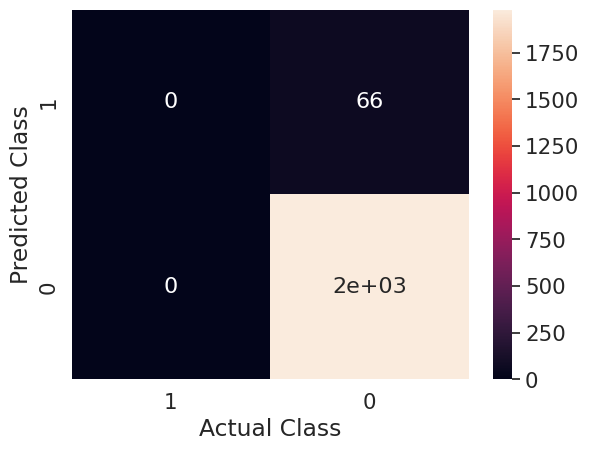

In [129]:
x_axis_labels = [1,0]
y_axis_labels = [1,0]

sns.set(font_scale=1.4)
sns.heatmap(knn_cm1, xticklabels = x_axis_labels, yticklabels = y_axis_labels, annot = True, annot_kws = {'size': 16})
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

### Hyperparameter tuning for KNN

In [130]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_knn = knn.predict(X_test)
    error_rate.append(np.mean(pred_knn != y_test))

Text(0, 0.5, 'Error Rate')

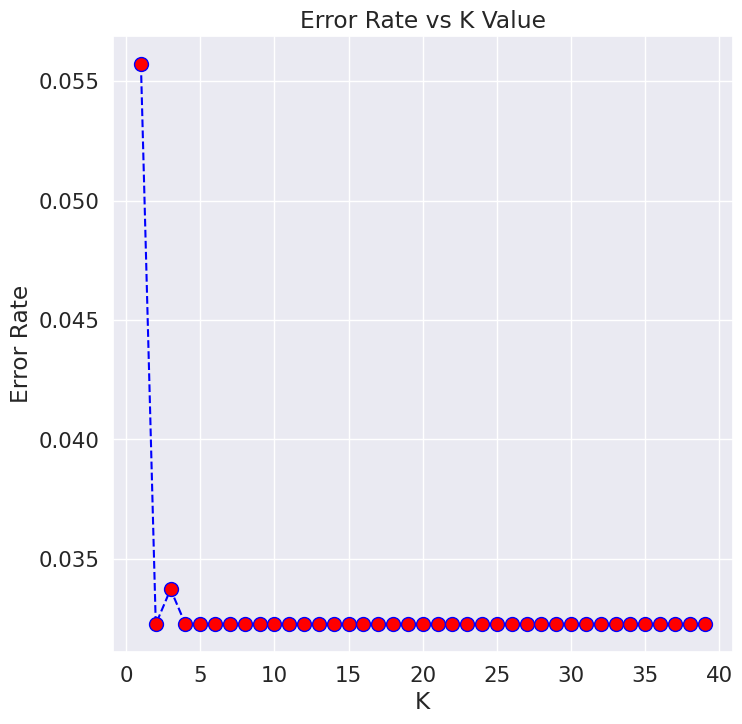

In [131]:
plt.figure(figsize = (8,8))
plt.plot(range(1,40), error_rate, color = 'blue', linestyle = 'dashed', marker = 'o', markerfacecolor = 'red', markersize = 10);
plt.title('Error Rate vs K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [132]:
## let's see how much difference does it makes

tuned_knn1 = KNeighborsClassifier(n_neighbors = 4)
tuned_knn1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [133]:
tuned_score1 = tuned_knn1.score(X_test, y_test)
print(tuned_score1)

0.967741935483871


Binary Classification with a XGBoost Classifier on Undersampled Data

 same as before, but this time I will use XGBoost instead of a random forest classifier.

In [134]:
# Instantiate the XGBoost classifier
xgb1 = XGBClassifier(objective='binary:logistic',random_state=42)

xgb1.fit(X_train_US2,y_underSampled)

# Use the model to predict on train data
xgb_train_preds = xgb1.predict(X_train_US2)

xgb_train_results = get_test_scores('XGB (train, undersampled)',xgb_train_preds,y_underSampled)
xgb_train_results

,model,precision,recall,F1,accuracy
0,"XGB (train, undersampled)",1.0,1.0,1.0,1.0


In [135]:
# Use the model to predict on test data
xgb_test_preds = xgb1.predict(X_test_US2)

xgb_test_results = get_test_scores('XGB (test, undersampling)',xgb_test_preds,y_test)
xgb_test_results   

,model,precision,recall,F1,accuracy
0,"XGB (test, undersampling)",0.564901,0.834343,0.566518,0.821114


results are worse than the random forest ones.

Binary Classification with a XGBoost Classifier (and GridSearch + Cross Validation) on Undersampled Data

I am using a XGBoost classifier with GridSearch and cross validation. This will make it possible to vary the parameter values and find the best combination of them.

In [136]:
# Instantiate the XGBoost classifier
xgb2 = XGBClassifier(objective='binary:logistic',random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth':[None,2,3,4,5],'min_child_weight':[4,5,6],'learning_rate': [0.01,0.05,0.1,0.2],
             'n_estimators':[150,200,300]}

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy','precision','recall','f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb2,cv_params,scoring=scoring,cv=4,refit='accuracy')

In [ ]:
# Model fitting on the train data
xgb_cv.fit(X_train_US2,y_underSampled)

In [ ]:
# Use the model to predict on the test data
xgb_cv_test_preds = xgb_cv.best_estimator_.predict(X_test_US2)

xgb_cv_test_results = get_test_scores('XGB CV (test, undersampling)',xgb_cv_test_preds,y_test)

xgb_cv_test_results   

These results are not better than those obtained with the random forest classifier.

Confusion Matrix

In [ ]:
# Generate array of values for confusion matrix
cm_rf_test     = confusion_matrix(y_test,rf_test_preds,labels=random_forest.classes_)
cm_xgb_test    = confusion_matrix(y_test,xgb_test_preds,labels=xgb1.classes_)
cm_xgb_cv_test = confusion_matrix(y_test,xgb_cv_test_preds,labels=xgb_cv.classes_)

### Creating the confusion matrices ###   
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,4))

ax1 = sns.heatmap(cm_rf_test,annot=True,ax=ax1,fmt='.4g')
ax1.xaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax1.yaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax1.set_title('Random Forest (Test)',fontsize=18)

ax2 = sns.heatmap(cm_xgb_test,annot=True,ax=ax2,fmt='.4g')
ax2.xaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax2.yaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax2.set_title('XGBoost (Test)',fontsize=18)

ax3 = sns.heatmap(cm_xgb_cv_test,annot=True,ax=ax3,fmt='.4g')
ax3.xaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax3.yaxis.set_ticklabels(['No Bankrupt','Bankrupt']) 
ax3.set_title('XGBoost CV (Test)',fontsize=18)

fig.suptitle("Confusion Matrices of Different Models (Undersampling)",fontsize=24) 

plt.tight_layout()
fig.set_facecolor('darkgrey')

The random forest classifier provides the best results with undersampling.